# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


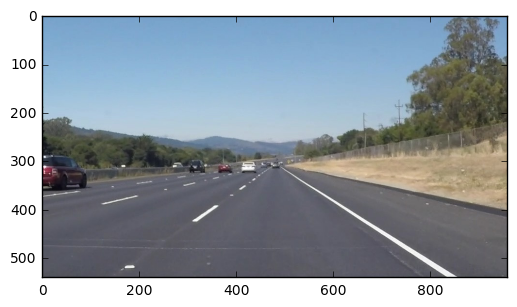

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [173]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def ave(num_list):
    if len(num_list) == 0:
        return 0
    result = int(sum(num_list)/len(num_list))
    return result

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    shape = img.shape  #(y,x)
    
    draw_height = 340
    left_top = []
    left_bottom = []
    right_top = []
    right_bottom = []
    left = []
    left_adj = []
    right = []
    right_adj = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            x_slope = x2-x1
            y_slope = y2-y1
            slope = (x2-x1)/ (y2-y1)
            
            if abs(y_slope/x_slope) > 0.5:  #this is to remove erronneous lines
                #seems line starts with x from the left most to the right, so check if y is upward or downward
                if y_slope > 0:  # right lane
                    cv2.line(img, (x1, y1), (x2, y2), color=[0,255,0], thickness=3)
                    
                    y1_adj = shape[0]  #bottom most the lanes will be drawn
                    x1_adj = x1 - int((y1-shape[0]) * slope)
                    
                    right_bottom.append(x1_adj)
                    
                    y2_adj = draw_height   #top most the lanes will be drawn
                    x2_adj = x2 - int((y2-draw_height) * slope)
                    right_top.append(x2_adj)                
                
                if y_slope < 0:  # left lane
                    cv2.line(img, (x1, y1), (x2, y2), color=[255,0,0], thickness=4)
                    
                    y1_adj = shape[0]  #bottom most the lanes will be drawn
                    x1_adj = x1 - int((y1-shape[0]) * slope)
                    
                    left_bottom.append(x1_adj)
                    
                    y2_adj = draw_height   #top most the lanes will be drawn
                    x2_adj = x2 - int((y2-draw_height) * slope)
                    left_top.append(x2_adj)
    
    cv2.line(img,
             ( ave(left_bottom) , y1_adj ),
             ( ave(left_top), y2_adj),
             color=[255,255,255],
             thickness=5
            )
    cv2.line(img,
             ( ave(right_bottom) , y1_adj ),
             ( ave(right_top), y2_adj),
             color=[255,255,255],
             thickness=5
            )                

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    #print('printing lines in hough_lines()', lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

            

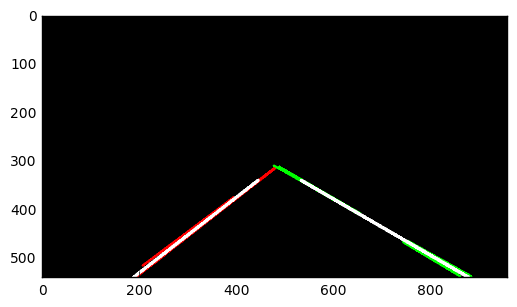

In [160]:
#### test updates on functions
#hough lines

#parameters
rho = 2
theta = np.pi/180
threshold = 20
min_line_len = 100
max_line_gap = 50
img_hough = hough_lines(img_mask,rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(img_hough)


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [161]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

shape of image
(540, 960, 3)


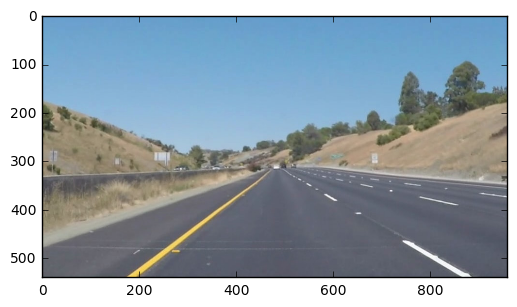

In [162]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

images = os.listdir("test_images/")

#image = mpimg.imread('test_images/solidWhiteRight.jpg')
img = mpimg.imread('test_images/'+str(images[5]))
print('shape of image')
print(img.shape)
plt.imshow(img)


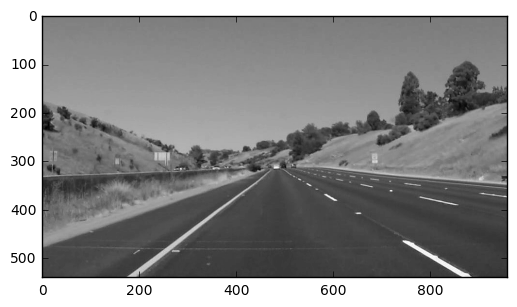

In [163]:
#convert to grayscale
img_gray = grayscale(img)
plt.imshow(img_gray, cmap='gray')

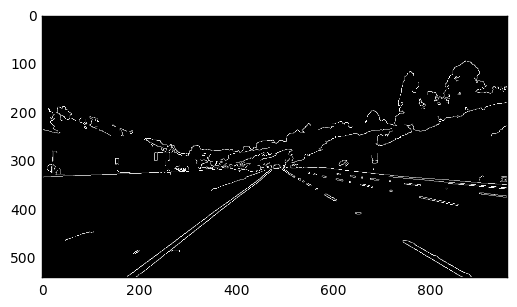

In [164]:
#get edges using canny

img_canny = canny(img_gray,100,200)
plt.imshow(img_canny,cmap='Greys_r')

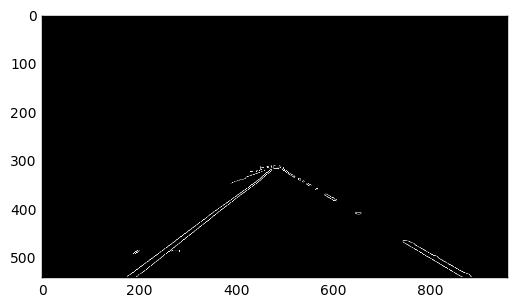

In [165]:
#region masking
vertices = np.array(
    [[(60,540),
      (450,310),
      (490,310),
      (900,540)]], dtype=np.int32)
img_mask = region_of_interest(img_canny,vertices)
plt.imshow(img_mask,cmap='Greys_r')

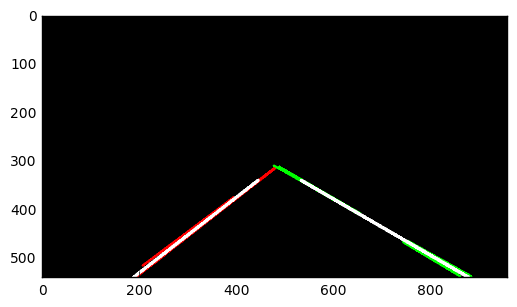

In [166]:
#hough lines

#parameters
rho = 2
theta = np.pi/180
threshold = 20
min_line_len = 100
max_line_gap = 50
img_hough = hough_lines(img_mask,rho, theta, threshold, min_line_len, max_line_gap)
plt.imshow(img_hough)

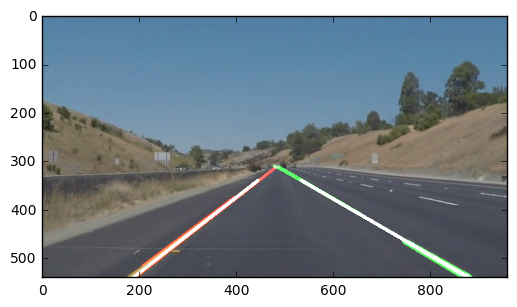

In [167]:
#draw hough_lines in canny image

img_combined = weighted_img(img_hough, img)
plt.imshow(img_combined)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [168]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [169]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    vertices = np.array(
                        [[
                          (60,540),
                          (450, 310), #450, 310
                          (490, 310),  #490, 310
                          (900, 540)
                        ]],
                        dtype=np.int32)
    #img = mpimg.imread(image)

    
    img_gray = grayscale(image)
    
    img_blur = gaussian_blur(img_gray,1)  #1
    img_canny = canny(img_gray,100,200)
    img_mask = region_of_interest(img_canny,vertices)
    rho = 2
    theta = np.pi/180
    threshold = 20 #10  # 20
    min_line_len = 100 #50 #100
    max_line_gap = 50 #25  # 50
    img_hough = hough_lines(img_mask, rho, theta, threshold, min_line_len, max_line_gap)
    img_combined = weighted_img(img_hough,image)
    
    return img_combined


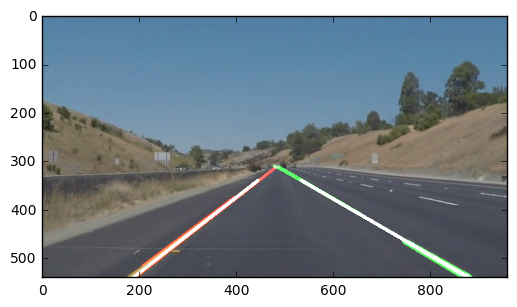

In [174]:
asd = process_image(img)
plt.imshow(asd)
#for x1,y1,x2,y2

Let's try the one with the solid white lane on the right first ...

In [171]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.92it/s]     | 5/222 [00:00<00:04, 49.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.83 s, sys: 833 ms, total: 3.67 s
Wall time: 7.45 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Issue with my algorithm is that it's still picking up a lot of noise and gets confused it as the lane lines. I'm having a hard time wrapping my head around tweaking the parameters of the blur and hough lines. Specifically, 

Potentially i can 

Apply color thresholds to make the lanes pop before doing canny

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [151]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(x1, y1), (x2,y2) - red is original:  491 533 669 417
(x1, y1), (x2,y2) - red is original:  469 540 665 418
(x1, y1), (x2,y2) - red is original:  482 540 671 417
(x1, y1), (x2,y2) - red is original:  412 435 515 369
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 0/251 [00:00<?, ?it/s]  1%|          | 3/251 [00:00<00:09, 26.66it/s]

(x1, y1), (x2,y2) - red is original:  491 533 669 417
(x1, y1), (x2,y2) - red is original:  469 540 665 418
(x1, y1), (x2,y2) - red is original:  482 540 671 417
(x1, y1), (x2,y2) - red is original:  412 435 515 369
(x1, y1), (x2,y2) - red is original:  469 540 668 416
(x1, y1), (x2,y2) - red is original:  483 539 672 416
(x1, y1), (x2,y2) - red is original:  551 493 679 416
(x1, y1), (x2,y2) - red is original:  558 483 679 421
(x1, y1), (x2,y2) - red is original:  535 506 668 413
(x1, y1), (x2,y2) - red is original:  285 443 397 359
(x1, y1), (x2,y2) - red is original:  403 435 510 376
(x1, y1), (x2,y2) - red is original:  484 539 666 416
(x1, y1), (x2,y2) - red is original:  471 540 663 416
(x1, y1), (x2,y2) - red is original:  483 540 675 415
(x1, y1), (x2,y2) - red is original:  486 540 645 429
(x1, y1), (x2,y2) - red is original:  472 540 641 430
(x1, y1), (x2,y2) - red is original:  500 523 669 417
(x1, y1), (x2,y2) - red is original:  475 540 675 420
(x1, y1), (x2,y2) - red is o

  2%|▏         | 6/251 [00:00<00:08, 27.41it/s]

(x1, y1), (x2,y2) - red is original:  504 529 660 424
(x1, y1), (x2,y2) - red is original:  477 540 660 421
(x1, y1), (x2,y2) - red is original:  523 508 682 420
(x1, y1), (x2,y2) - red is original:  540 497 683 418
(x1, y1), (x2,y2) - red is original:  441 518 548 386
(x1, y1), (x2,y2) - red is original:  436 516 436 364


  3%|▎         | 8/251 [00:00<00:11, 21.99it/s]

(x1, y1), (x2,y2) - red is original:  499 532 663 417
(x1, y1), (x2,y2) - red is original:  476 540 666 417
(x1, y1), (x2,y2) - red is original:  546 493 679 416
(x1, y1), (x2,y2) - red is original:  514 514 680 418
(x1, y1), (x2,y2) - red is original:  391 435 501 372
(x1, y1), (x2,y2) - red is original:  502 530 662 417
(x1, y1), (x2,y2) - red is original:  477 540 663 415
(x1, y1), (x2,y2) - red is original:  545 500 668 417
(x1, y1), (x2,y2) - red is original:  525 514 658 428
(x1, y1), (x2,y2) - red is original:  516 513 620 448
(x1, y1), (x2,y2) - red is original:  488 540 664 417
(x1, y1), (x2,y2) - red is original:  476 540 584 468
(x1, y1), (x2,y2) - red is original:  490 540 660 421


  4%|▍         | 11/251 [00:00<00:10, 22.55it/s]

(x1, y1), (x2,y2) - red is original:  532 503 680 417
(x1, y1), (x2,y2) - red is original:  497 536 658 415
(x1, y1), (x2,y2) - red is original:  507 520 680 420
(x1, y1), (x2,y2) - red is original:  479 540 652 424
(x1, y1), (x2,y2) - red is original:  477 540 582 470
(x1, y1), (x2,y2) - red is original:  499 534 625 446
(x1, y1), (x2,y2) - red is original:  481 540 660 419
(x1, y1), (x2,y2) - red is original:  497 536 667 417
(x1, y1), (x2,y2) - red is original:  545 495 680 420


  6%|▌         | 14/251 [00:00<00:10, 22.91it/s]

(x1, y1), (x2,y2) - red is original:  491 540 666 413
(x1, y1), (x2,y2) - red is original:  562 484 682 420
(x1, y1), (x2,y2) - red is original:  560 489 662 422
(x1, y1), (x2,y2) - red is original:  556 492 677 416
(x1, y1), (x2,y2) - red is original:  514 515 666 416
(x1, y1), (x2,y2) - red is original:  492 539 660 417
(x1, y1), (x2,y2) - red is original:  574 480 676 416
(x1, y1), (x2,y2) - red is original:  520 519 634 443
(x1, y1), (x2,y2) - red is original:  377 435 490 367
(x1, y1), (x2,y2) - red is original:  511 518 668 423
(x1, y1), (x2,y2) - red is original:  544 494 652 424
(x1, y1), (x2,y2) - red is original:  510 525 665 416
(x1, y1), (x2,y2) - red is original:  478 540 663 415
(x1, y1), (x2,y2) - red is original:  490 540 668 416
(x1, y1), (x2,y2) - red is original:  540 496 679 419
(x1, y1), (x2,y2) - red is original:  489 540 661 415
(x1, y1), (x2,y2) - red is original:  489 531 654 419
(x1, y1), (x2,y2) - red is original:  568 486 669 415
(x1, y1), (x2,y2) - red is o

  7%|▋         | 17/251 [00:00<00:10, 23.07it/s]

(x1, y1), (x2,y2) - red is original:  492 537 661 418
(x1, y1), (x2,y2) - red is original:  476 540 657 418
(x1, y1), (x2,y2) - red is original:  551 494 673 420
(x1, y1), (x2,y2) - red is original:  546 502 649 418
(x1, y1), (x2,y2) - red is original:  356 436 475 368
(x1, y1), (x2,y2) - red is original:  552 504 638 394
(x1, y1), (x2,y2) - red is original:  489 540 660 416
(x1, y1), (x2,y2) - red is original:  521 510 656 416
(x1, y1), (x2,y2) - red is original:  564 484 665 423
(x1, y1), (x2,y2) - red is original:  345 436 447 384
(x1, y1), (x2,y2) - red is original:  502 521 632 446
(x1, y1), (x2,y2) - red is original:  500 531 660 418
(x1, y1), (x2,y2) - red is original:  476 540 657 418
(x1, y1), (x2,y2) - red is original:  523 515 668 417


  8%|▊         | 20/251 [00:00<00:09, 24.32it/s]  9%|▉         | 23/251 [00:00<00:09, 25.26it/s]

(x1, y1), (x2,y2) - red is original:  476 540 673 417
(x1, y1), (x2,y2) - red is original:  508 518 662 418
(x1, y1), (x2,y2) - red is original:  535 506 665 424
(x1, y1), (x2,y2) - red is original:  455 533 590 366
(x1, y1), (x2,y2) - red is original:  528 511 630 425
(x1, y1), (x2,y2) - red is original:  345 440 464 366
(x1, y1), (x2,y2) - red is original:  493 538 653 417
(x1, y1), (x2,y2) - red is original:  489 540 653 417
(x1, y1), (x2,y2) - red is original:  475 540 657 417
(x1, y1), (x2,y2) - red is original:  530 502 680 419
(x1, y1), (x2,y2) - red is original:  552 487 671 418
(x1, y1), (x2,y2) - red is original:  496 526 673 424
(x1, y1), (x2,y2) - red is original:  486 533 589 475
(x1, y1), (x2,y2) - red is original:  537 497 678 419
(x1, y1), (x2,y2) - red is original:  490 540 634 423
(x1, y1), (x2,y2) - red is original:  479 538 588 475
(x1, y1), (x2,y2) - red is original:  492 539 627 433


 10%|█         | 26/251 [00:01<00:08, 25.64it/s]

(x1, y1), (x2,y2) - red is original:  489 540 652 418
(x1, y1), (x2,y2) - red is original:  502 521 667 422
(x1, y1), (x2,y2) - red is original:  502 528 667 416
(x1, y1), (x2,y2) - red is original:  492 527 659 418
(x1, y1), (x2,y2) - red is original:  487 540 655 418
(x1, y1), (x2,y2) - red is original:  474 540 580 479
(x1, y1), (x2,y2) - red is original:  499 523 599 463
(x1, y1), (x2,y2) - red is original:  338 432 458 365
(x1, y1), (x2,y2) - red is original:  546 490 685 419
(x1, y1), (x2,y2) - red is original:  486 540 654 422
(x1, y1), (x2,y2) - red is original:  505 518 657 419
(x1, y1), (x2,y2) - red is original:  474 540 574 482
(x1, y1), (x2,y2) - red is original:  318 441 453 367
(x1, y1), (x2,y2) - red is original:  513 514 617 454
(x1, y1), (x2,y2) - red is original:  543 492 667 429


 12%|█▏        | 29/251 [00:01<00:08, 25.29it/s]

(x1, y1), (x2,y2) - red is original:  473 540 658 416
(x1, y1), (x2,y2) - red is original:  485 540 654 422
(x1, y1), (x2,y2) - red is original:  517 516 680 418
(x1, y1), (x2,y2) - red is original:  528 501 683 418
(x1, y1), (x2,y2) - red is original:  300 486 431 364
(x1, y1), (x2,y2) - red is original:  493 526 669 428
(x1, y1), (x2,y2) - red is original:  473 540 578 470
(x1, y1), (x2,y2) - red is original:  521 506 685 419
(x1, y1), (x2,y2) - red is original:  485 540 666 409
(x1, y1), (x2,y2) - red is original:  578 475 679 417
(x1, y1), (x2,y2) - red is original:  485 539 661 415
(x1, y1), (x2,y2) - red is original:  540 493 677 423
(x1, y1), (x2,y2) - red is original:  505 524 656 418
(x1, y1), (x2,y2) - red is original:  325 434 432 362
(x1, y1), (x2,y2) - red is original:  316 439 431 361


 13%|█▎        | 32/251 [00:01<00:08, 25.71it/s]

(x1, y1), (x2,y2) - red is original:  530 506 674 419
(x1, y1), (x2,y2) - red is original:  495 523 638 434
(x1, y1), (x2,y2) - red is original:  486 538 639 434
(x1, y1), (x2,y2) - red is original:  315 434 423 372
(x1, y1), (x2,y2) - red is original:  485 530 661 420
(x1, y1), (x2,y2) - red is original:  483 540 662 420
(x1, y1), (x2,y2) - red is original:  543 498 659 431
(x1, y1), (x2,y2) - red is original:  479 534 663 432
(x1, y1), (x2,y2) - red is original:  491 534 608 455
(x1, y1), (x2,y2) - red is original:  504 524 664 420
(x1, y1), (x2,y2) - red is original:  469 540 662 420
(x1, y1), (x2,y2) - red is original:  309 438 422 362
(x1, y1), (x2,y2) - red is original:  513 512 678 424
(x1, y1), (x2,y2) - red is original:  547 489 684 419
(x1, y1), (x2,y2) - red is original:  542 492 647 434
(x1, y1), (x2,y2) - red is original:  521 521 570 369
(x1, y1), (x2,y2) - red is original:  530 500 680 417
(x1, y1), (x2,y2) - red is original:  472 538 676 420
(x1, y1), (x2,y2) - red is o

 14%|█▍        | 36/251 [00:01<00:07, 27.21it/s]

(x1, y1), (x2,y2) - red is original:  485 540 645 424
(x1, y1), (x2,y2) - red is original:  509 514 659 434
(x1, y1), (x2,y2) - red is original:  524 505 673 416
(x1, y1), (x2,y2) - red is original:  538 496 679 424
(x1, y1), (x2,y2) - red is original:  483 540 663 414
(x1, y1), (x2,y2) - red is original:  523 505 682 424
(x1, y1), (x2,y2) - red is original:  472 538 572 485
(x1, y1), (x2,y2) - red is original:  532 507 641 419
(x1, y1), (x2,y2) - red is original:  567 480 673 417
(x1, y1), (x2,y2) - red is original:  543 500 665 418
(x1, y1), (x2,y2) - red is original:  469 540 600 459
(x1, y1), (x2,y2) - red is original:  491 533 676 417
(x1, y1), (x2,y2) - red is original:  483 540 591 465
(x1, y1), (x2,y2) - red is original:  544 493 672 419


 16%|█▌        | 40/251 [00:01<00:07, 27.92it/s]

(x1, y1), (x2,y2) - red is original:  554 492 680 419
(x1, y1), (x2,y2) - red is original:  558 484 673 420
(x1, y1), (x2,y2) - red is original:  575 478 681 419
(x1, y1), (x2,y2) - red is original:  554 488 659 420
(x1, y1), (x2,y2) - red is original:  549 496 549 347
(x1, y1), (x2,y2) - red is original:  540 501 678 424
(x1, y1), (x2,y2) - red is original:  502 526 643 441
(x1, y1), (x2,y2) - red is original:  491 535 596 391
(x1, y1), (x2,y2) - red is original:  519 509 677 425
(x1, y1), (x2,y2) - red is original:  484 540 660 417
(x1, y1), (x2,y2) - red is original:  538 503 667 431
(x1, y1), (x2,y2) - red is original:  546 492 647 440
(x1, y1), (x2,y2) - red is original:  559 489 670 425
(x1, y1), (x2,y2) - red is original:  554 487 674 420
(x1, y1), (x2,y2) - red is original:  407 434 496 332
(x1, y1), (x2,y2) - red is original:  483 540 671 418
(x1, y1), (x2,y2) - red is original:  516 511 673 416
(x1, y1), (x2,y2) - red is original:  510 515 683 419
(x1, y1), (x2,y2) - red is o

 17%|█▋        | 43/251 [00:01<00:07, 26.72it/s]

(x1, y1), (x2,y2) - red is original:  527 513 670 413
(x1, y1), (x2,y2) - red is original:  544 494 680 425
(x1, y1), (x2,y2) - red is original:  498 533 653 421
(x1, y1), (x2,y2) - red is original:  496 525 669 421
(x1, y1), (x2,y2) - red is original:  508 462 539 347
(x1, y1), (x2,y2) - red is original:  258 445 383 351
(x1, y1), (x2,y2) - red is original:  556 492 681 420
(x1, y1), (x2,y2) - red is original:  514 463 537 340
(x1, y1), (x2,y2) - red is original:  488 514 517 378
(x1, y1), (x2,y2) - red is original:  552 495 552 351
(x1, y1), (x2,y2) - red is original:  511 464 513 361
(x1, y1), (x2,y2) - red is original:  487 540 674 414
(x1, y1), (x2,y2) - red is original:  510 516 673 418
(x1, y1), (x2,y2) - red is original:  516 524 639 424
(x1, y1), (x2,y2) - red is original:  561 488 664 426
(x1, y1), (x2,y2) - red is original:  473 540 667 419
(x1, y1), (x2,y2) - red is original:  370 438 504 344


 18%|█▊        | 46/251 [00:01<00:08, 25.35it/s]

(x1, y1), (x2,y2) - red is original:  489 539 674 414
(x1, y1), (x2,y2) - red is original:  480 538 669 416
(x1, y1), (x2,y2) - red is original:  478 472 527 361
(x1, y1), (x2,y2) - red is original:  564 487 675 420
(x1, y1), (x2,y2) - red is original:  544 496 670 420
(x1, y1), (x2,y2) - red is original:  555 493 671 426
(x1, y1), (x2,y2) - red is original:  506 528 639 428
(x1, y1), (x2,y2) - red is original:  543 496 676 425
(x1, y1), (x2,y2) - red is original:  491 540 667 412
(x1, y1), (x2,y2) - red is original:  554 489 674 420
(x1, y1), (x2,y2) - red is original:  535 501 684 422
(x1, y1), (x2,y2) - red is original:  489 540 657 418
(x1, y1), (x2,y2) - red is original:  472 430 487 324
(x1, y1), (x2,y2) - red is original:  478 539 672 413
(x1, y1), (x2,y2) - red is original:  508 526 666 419
(x1, y1), (x2,y2) - red is original:  519 519 660 427
(x1, y1), (x2,y2) - red is original:  527 514 680 419
(x1, y1), (x2,y2) - red is original:  478 540 588 468
(x1, y1), (x2,y2) - red is o

 20%|█▉        | 49/251 [00:02<00:09, 20.71it/s]

(x1, y1), (x2,y2) - red is original:  480 538 680 417
(x1, y1), (x2,y2) - red is original:  496 527 674 420
(x1, y1), (x2,y2) - red is original:  533 509 661 432
(x1, y1), (x2,y2) - red is original:  362 378 489 313
(x1, y1), (x2,y2) - red is original:  558 486 672 420
(x1, y1), (x2,y2) - red is original:  521 518 679 419
(x1, y1), (x2,y2) - red is original:  338 432 497 325
(x1, y1), (x2,y2) - red is original:  232 441 342 375
(x1, y1), (x2,y2) - red is original:  333 441 496 318
(x1, y1), (x2,y2) - red is original:  499 527 669 413
(x1, y1), (x2,y2) - red is original:  489 532 675 420
(x1, y1), (x2,y2) - red is original:  472 432 583 363
(x1, y1), (x2,y2) - red is original:  500 534 669 412
(x1, y1), (x2,y2) - red is original:  531 504 669 421
(x1, y1), (x2,y2) - red is original:  569 488 679 417
(x1, y1), (x2,y2) - red is original:  435 430 560 361
(x1, y1), (x2,y2) - red is original:  476 432 476 323
(x1, y1), (x2,y2) - red is original:  518 513 625 453
(x1, y1), (x2,y2) - red is o

 21%|██        | 52/251 [00:02<00:10, 18.20it/s]

(x1, y1), (x2,y2) - red is original:  502 523 678 421
(x1, y1), (x2,y2) - red is original:  562 483 679 421
(x1, y1), (x2,y2) - red is original:  440 434 567 369
(x1, y1), (x2,y2) - red is original:  490 540 672 413
(x1, y1), (x2,y2) - red is original:  432 434 576 358
(x1, y1), (x2,y2) - red is original:  495 536 662 419
(x1, y1), (x2,y2) - red is original:  501 428 501 325
(x1, y1), (x2,y2) - red is original:  497 527 672 413
(x1, y1), (x2,y2) - red is original:  488 533 681 417
(x1, y1), (x2,y2) - red is original:  522 518 663 412
(x1, y1), (x2,y2) - red is original:  439 434 547 350
(x1, y1), (x2,y2) - red is original:  511 525 666 421
(x1, y1), (x2,y2) - red is original:  478 540 674 413
(x1, y1), (x2,y2) - red is original:  457 433 564 361


 22%|██▏       | 54/251 [00:02<00:12, 16.03it/s]

(x1, y1), (x2,y2) - red is original:  488 540 671 412
(x1, y1), (x2,y2) - red is original:  556 487 668 412
(x1, y1), (x2,y2) - red is original:  531 502 664 431
(x1, y1), (x2,y2) - red is original:  489 540 669 410
(x1, y1), (x2,y2) - red is original:  528 504 638 438


 22%|██▏       | 56/251 [00:02<00:12, 15.40it/s]

(x1, y1), (x2,y2) - red is original:  489 540 670 413
(x1, y1), (x2,y2) - red is original:  476 540 672 413
(x1, y1), (x2,y2) - red is original:  476 469 492 311
(x1, y1), (x2,y2) - red is original:  520 510 680 421
(x1, y1), (x2,y2) - red is original:  484 470 498 314
(x1, y1), (x2,y2) - red is original:  463 429 473 314
(x1, y1), (x2,y2) - red is original:  469 432 484 323
(x1, y1), (x2,y2) - red is original:  551 495 680 420
(x1, y1), (x2,y2) - red is original:  560 485 676 418
(x1, y1), (x2,y2) - red is original:  456 478 480 310
(x1, y1), (x2,y2) - red is original:  492 539 661 412
(x1, y1), (x2,y2) - red is original:  348 378 466 310
(x1, y1), (x2,y2) - red is original:  381 366 485 311
(x1, y1), (x2,y2) - red is original:  347 437 532 343
(x1, y1), (x2,y2) - red is original:  447 433 447 315
(x1, y1), (x2,y2) - red is original:  420 435 565 361
(x1, y1), (x2,y2) - red is original:  374 438 467 319
(x1, y1), (x2,y2) - red is original:  561 488 673 423
(x1, y1), (x2,y2) - red is o

 23%|██▎       | 58/251 [00:02<00:12, 14.87it/s] 24%|██▍       | 60/251 [00:02<00:12, 14.94it/s]

(x1, y1), (x2,y2) - red is original:  418 435 528 336
(x1, y1), (x2,y2) - red is original:  389 372 491 311
(x1, y1), (x2,y2) - red is original:  490 539 672 412
(x1, y1), (x2,y2) - red is original:  414 433 522 329
(x1, y1), (x2,y2) - red is original:  346 373 457 314
(x1, y1), (x2,y2) - red is original:  399 434 488 311
(x1, y1), (x2,y2) - red is original:  453 410 556 353
(x1, y1), (x2,y2) - red is original:  424 424 479 311
(x1, y1), (x2,y2) - red is original:  476 540 670 414
(x1, y1), (x2,y2) - red is original:  487 540 674 414
(x1, y1), (x2,y2) - red is original:  379 371 479 311
(x1, y1), (x2,y2) - red is original:  427 434 462 312
(x1, y1), (x2,y2) - red is original:  401 436 519 326
(x1, y1), (x2,y2) - red is original:  465 432 465 330
(x1, y1), (x2,y2) - red is original:  439 433 485 312
(x1, y1), (x2,y2) - red is original:  475 469 481 310
(x1, y1), (x2,y2) - red is original:  437 433 474 331
(x1, y1), (x2,y2) - red is original:  447 428 491 320
(x1, y1), (x2,y2) - red is o

 25%|██▍       | 62/251 [00:02<00:12, 14.92it/s]

(x1, y1), (x2,y2) - red is original:  484 540 671 414
(x1, y1), (x2,y2) - red is original:  473 540 667 414
(x1, y1), (x2,y2) - red is original:  372 431 512 347
(x1, y1), (x2,y2) - red is original:  404 429 459 310
(x1, y1), (x2,y2) - red is original:  513 533 644 423
(x1, y1), (x2,y2) - red is original:  394 373 496 314
(x1, y1), (x2,y2) - red is original:  286 441 463 322
(x1, y1), (x2,y2) - red is original:  363 379 487 310
(x1, y1), (x2,y2) - red is original:  526 506 669 414
(x1, y1), (x2,y2) - red is original:  349 377 462 310
(x1, y1), (x2,y2) - red is original:  568 485 674 413
(x1, y1), (x2,y2) - red is original:  391 379 494 312
(x1, y1), (x2,y2) - red is original:  363 380 491 312
(x1, y1), (x2,y2) - red is original:  396 389 506 328
(x1, y1), (x2,y2) - red is original:  484 533 674 414
(x1, y1), (x2,y2) - red is original:  559 490 675 420
(x1, y1), (x2,y2) - red is original:  296 441 512 322
(x1, y1), (x2,y2) - red is original:  358 375 484 310
(x1, y1), (x2,y2) - red is o

 25%|██▌       | 64/251 [00:03<00:12, 14.73it/s]

(x1, y1), (x2,y2) - red is original:  379 435 536 341
(x1, y1), (x2,y2) - red is original:  387 402 492 311
(x1, y1), (x2,y2) - red is original:  370 379 492 312
(x1, y1), (x2,y2) - red is original:  232 444 456 310
(x1, y1), (x2,y2) - red is original:  488 464 512 328
(x1, y1), (x2,y2) - red is original:  298 437 446 313
(x1, y1), (x2,y2) - red is original:  370 395 498 315
(x1, y1), (x2,y2) - red is original:  361 436 447 314
(x1, y1), (x2,y2) - red is original:  341 384 457 314
(x1, y1), (x2,y2) - red is original:  510 523 663 424
(x1, y1), (x2,y2) - red is original:  375 435 478 321
(x1, y1), (x2,y2) - red is original:  306 437 457 310
(x1, y1), (x2,y2) - red is original:  325 436 457 317
(x1, y1), (x2,y2) - red is original:  380 425 489 327
(x1, y1), (x2,y2) - red is original:  562 488 662 415
(x1, y1), (x2,y2) - red is original:  346 435 496 314
(x1, y1), (x2,y2) - red is original:  408 430 533 335
(x1, y1), (x2,y2) - red is original:  372 435 483 312
(x1, y1), (x2,y2) - red is o

 26%|██▋       | 66/251 [00:03<00:13, 14.19it/s]

(x1, y1), (x2,y2) - red is original:  494 527 675 414
(x1, y1), (x2,y2) - red is original:  546 499 679 419
(x1, y1), (x2,y2) - red is original:  315 439 499 315
(x1, y1), (x2,y2) - red is original:  364 432 472 313
(x1, y1), (x2,y2) - red is original:  480 469 480 320
(x1, y1), (x2,y2) - red is original:  494 535 669 421
(x1, y1), (x2,y2) - red is original:  475 540 676 414
(x1, y1), (x2,y2) - red is original:  547 502 656 423
(x1, y1), (x2,y2) - red is original:  299 440 463 312
(x1, y1), (x2,y2) - red is original:  382 433 451 314
(x1, y1), (x2,y2) - red is original:  484 465 492 313
(x1, y1), (x2,y2) - red is original:  511 523 625 449
(x1, y1), (x2,y2) - red is original:  411 434 475 323
(x1, y1), (x2,y2) - red is original:  386 418 525 331
(x1, y1), (x2,y2) - red is original:  336 436 454 314
(x1, y1), (x2,y2) - red is original:  344 435 495 313
(x1, y1), (x2,y2) - red is original:  397 435 447 317
(x1, y1), (x2,y2) - red is original:  488 532 676 414
(x1, y1), (x2,y2) - red is o

 27%|██▋       | 68/251 [00:03<00:12, 14.38it/s]

(x1, y1), (x2,y2) - red is original:  530 512 671 420
(x1, y1), (x2,y2) - red is original:  254 443 448 312
(x1, y1), (x2,y2) - red is original:  480 540 665 415
(x1, y1), (x2,y2) - red is original:  311 394 449 323
(x1, y1), (x2,y2) - red is original:  351 438 430 326
(x1, y1), (x2,y2) - red is original:  349 438 415 333
(x1, y1), (x2,y2) - red is original:  456 476 482 312
(x1, y1), (x2,y2) - red is original:  364 437 505 323
(x1, y1), (x2,y2) - red is original:  305 438 452 315
(x1, y1), (x2,y2) - red is original:  528 514 642 425
(x1, y1), (x2,y2) - red is original:  221 445 487 310
(x1, y1), (x2,y2) - red is original:  358 437 453 328
(x1, y1), (x2,y2) - red is original:  311 392 450 315
(x1, y1), (x2,y2) - red is original:  359 390 481 322
(x1, y1), (x2,y2) - red is original:  346 438 501 317
(x1, y1), (x2,y2) - red is original:  324 385 448 319
(x1, y1), (x2,y2) - red is original:  339 390 441 318
(x1, y1), (x2,y2) - red is original:  348 417 447 315
(x1, y1), (x2,y2) - red is o

 28%|██▊       | 70/251 [00:03<00:12, 14.59it/s]

(x1, y1), (x2,y2) - red is original:  291 443 486 311
(x1, y1), (x2,y2) - red is original:  496 539 671 416
(x1, y1), (x2,y2) - red is original:  287 440 471 316
(x1, y1), (x2,y2) - red is original:  293 440 485 310
(x1, y1), (x2,y2) - red is original:  297 440 494 313
(x1, y1), (x2,y2) - red is original:  315 441 497 314
(x1, y1), (x2,y2) - red is original:  483 540 667 416
(x1, y1), (x2,y2) - red is original:  268 444 454 314
(x1, y1), (x2,y2) - red is original:  350 426 488 311
(x1, y1), (x2,y2) - red is original:  300 440 521 328
(x1, y1), (x2,y2) - red is original:  286 440 470 316
(x1, y1), (x2,y2) - red is original:  266 444 422 331
(x1, y1), (x2,y2) - red is original:  319 389 427 326
(x1, y1), (x2,y2) - red is original:  272 444 470 311
(x1, y1), (x2,y2) - red is original:  281 441 472 312
(x1, y1), (x2,y2) - red is original:  319 393 462 310
(x1, y1), (x2,y2) - red is original:  496 530 638 448
(x1, y1), (x2,y2) - red is original:  349 439 492 315
(x1, y1), (x2,y2) - red is o

 29%|██▊       | 72/251 [00:03<00:12, 14.20it/s]

(x1, y1), (x2,y2) - red is original:  542 506 667 431
(x1, y1), (x2,y2) - red is original:  305 439 511 325
(x1, y1), (x2,y2) - red is original:  327 440 433 326
(x1, y1), (x2,y2) - red is original:  426 492 497 317
(x1, y1), (x2,y2) - red is original:  314 441 491 351
(x1, y1), (x2,y2) - red is original:  317 441 484 311
(x1, y1), (x2,y2) - red is original:  317 410 490 315
(x1, y1), (x2,y2) - red is original:  391 435 461 314
(x1, y1), (x2,y2) - red is original:  318 396 460 311
(x1, y1), (x2,y2) - red is original:  496 540 659 417
(x1, y1), (x2,y2) - red is original:  484 445 508 320
(x1, y1), (x2,y2) - red is original:  383 436 491 342
(x1, y1), (x2,y2) - red is original:  414 440 490 314
(x1, y1), (x2,y2) - red is original:  365 371 472 310
(x1, y1), (x2,y2) - red is original:  342 433 502 337
(x1, y1), (x2,y2) - red is original:  435 431 452 312
(x1, y1), (x2,y2) - red is original:  507 532 678 416
(x1, y1), (x2,y2) - red is original:  484 540 671 419
(x1, y1), (x2,y2) - red is o

 29%|██▉       | 74/251 [00:03<00:12, 13.62it/s]

(x1, y1), (x2,y2) - red is original:  484 540 674 417
(x1, y1), (x2,y2) - red is original:  237 444 492 314
(x1, y1), (x2,y2) - red is original:  312 391 464 310
(x1, y1), (x2,y2) - red is original:  538 510 670 421
(x1, y1), (x2,y2) - red is original:  338 376 460 311
(x1, y1), (x2,y2) - red is original:  238 447 497 315
(x1, y1), (x2,y2) - red is original:  310 394 466 311
(x1, y1), (x2,y2) - red is original:  391 489 465 314
(x1, y1), (x2,y2) - red is original:  409 479 433 329
(x1, y1), (x2,y2) - red is original:  497 540 627 452
(x1, y1), (x2,y2) - red is original:  277 444 482 340
(x1, y1), (x2,y2) - red is original:  283 417 492 311
(x1, y1), (x2,y2) - red is original:  280 438 499 316
(x1, y1), (x2,y2) - red is original:  521 515 671 421
(x1, y1), (x2,y2) - red is original:  392 503 454 313
(x1, y1), (x2,y2) - red is original:  526 519 684 420
(x1, y1), (x2,y2) - red is original:  327 438 429 328
(x1, y1), (x2,y2) - red is original:  320 429 497 314
(x1, y1), (x2,y2) - red is o

 30%|███       | 76/251 [00:03<00:13, 13.41it/s]

(x1, y1), (x2,y2) - red is original:  487 540 674 414
(x1, y1), (x2,y2) - red is original:  296 443 495 319
(x1, y1), (x2,y2) - red is original:  499 540 672 419
(x1, y1), (x2,y2) - red is original:  484 470 484 310
(x1, y1), (x2,y2) - red is original:  237 447 459 334
(x1, y1), (x2,y2) - red is original:  402 494 444 314
(x1, y1), (x2,y2) - red is original:  322 385 457 310
(x1, y1), (x2,y2) - red is original:  390 497 429 326
(x1, y1), (x2,y2) - red is original:  570 493 674 420
(x1, y1), (x2,y2) - red is original:  400 495 433 327
(x1, y1), (x2,y2) - red is original:  252 446 470 310
(x1, y1), (x2,y2) - red is original:  515 520 622 453
(x1, y1), (x2,y2) - red is original:  371 508 463 312
(x1, y1), (x2,y2) - red is original:  324 441 423 327
(x1, y1), (x2,y2) - red is original:  303 440 497 319
(x1, y1), (x2,y2) - red is original:  289 441 498 315
(x1, y1), (x2,y2) - red is original:  365 509 453 321
(x1, y1), (x2,y2) - red is original:  408 433 428 323
(x1, y1), (x2,y2) - red is o

 31%|███       | 78/251 [00:04<00:12, 13.78it/s]

(x1, y1), (x2,y2) - red is original:  509 536 664 420
(x1, y1), (x2,y2) - red is original:  491 540 668 416
(x1, y1), (x2,y2) - red is original:  238 447 456 316
(x1, y1), (x2,y2) - red is original:  221 448 447 318
(x1, y1), (x2,y2) - red is original:  279 411 444 319
(x1, y1), (x2,y2) - red is original:  317 463 431 323
(x1, y1), (x2,y2) - red is original:  319 455 433 329
(x1, y1), (x2,y2) - red is original:  334 378 444 314
(x1, y1), (x2,y2) - red is original:  504 538 618 458
(x1, y1), (x2,y2) - red is original:  295 465 420 330
(x1, y1), (x2,y2) - red is original:  274 539 480 395
(x1, y1), (x2,y2) - red is original:  270 444 383 350
(x1, y1), (x2,y2) - red is original:  298 464 452 310
(x1, y1), (x2,y2) - red is original:  353 512 407 336
(x1, y1), (x2,y2) - red is original:  260 442 398 342
(x1, y1), (x2,y2) - red is original:  250 437 433 327
(x1, y1), (x2,y2) - red is original:  507 513 626 389
(x1, y1), (x2,y2) - red is original:  389 502 389 347
(x1, y1), (x2,y2) - red is o

 32%|███▏      | 80/251 [00:04<00:12, 13.25it/s]

(x1, y1), (x2,y2) - red is original:  501 540 673 415
(x1, y1), (x2,y2) - red is original:  516 521 677 416
(x1, y1), (x2,y2) - red is original:  237 472 468 317
(x1, y1), (x2,y2) - red is original:  231 471 379 367
(x1, y1), (x2,y2) - red is original:  247 465 380 372
(x1, y1), (x2,y2) - red is original:  502 532 583 401
(x1, y1), (x2,y2) - red is original:  234 472 378 371
(x1, y1), (x2,y2) - red is original:  231 472 374 368
(x1, y1), (x2,y2) - red is original:  470 531 641 407
(x1, y1), (x2,y2) - red is original:  495 537 620 408
(x1, y1), (x2,y2) - red is original:  537 506 670 419
(x1, y1), (x2,y2) - red is original:  246 534 251 427
(x1, y1), (x2,y2) - red is original:  296 439 464 317
(x1, y1), (x2,y2) - red is original:  503 500 642 413
(x1, y1), (x2,y2) - red is original:  510 525 664 429
(x1, y1), (x2,y2) - red is original:  296 524 326 419
(x1, y1), (x2,y2) - red is original:  236 459 372 367
(x1, y1), (x2,y2) - red is original:  529 491 642 409
(x1, y1), (x2,y2) - red is o

 33%|███▎      | 82/251 [00:04<00:12, 13.34it/s]

(x1, y1), (x2,y2) - red is original:  503 539 675 414
(x1, y1), (x2,y2) - red is original:  490 540 669 415
(x1, y1), (x2,y2) - red is original:  204 477 371 373
(x1, y1), (x2,y2) - red is original:  457 539 630 399
(x1, y1), (x2,y2) - red is original:  256 473 373 375
(x1, y1), (x2,y2) - red is original:  249 473 368 370
(x1, y1), (x2,y2) - red is original:  340 508 340 375
(x1, y1), (x2,y2) - red is original:  331 465 469 395
(x1, y1), (x2,y2) - red is original:  487 504 640 408
(x1, y1), (x2,y2) - red is original:  269 534 366 373
(x1, y1), (x2,y2) - red is original:  369 461 469 399
(x1, y1), (x2,y2) - red is original:  208 477 346 384
(x1, y1), (x2,y2) - red is original:  258 539 362 391
(x1, y1), (x2,y2) - red is original:  504 539 669 415
(x1, y1), (x2,y2) - red is original:  502 531 675 414
(x1, y1), (x2,y2) - red is original:  161 481 292 414
(x1, y1), (x2,y2) - red is original:  467 513 633 405
(x1, y1), (x2,y2) - red is original:  490 540 600 465
(x1, y1), (x2,y2) - red is o

 33%|███▎      | 84/251 [00:04<00:12, 13.32it/s]

(x1, y1), (x2,y2) - red is original:  504 540 671 414
(x1, y1), (x2,y2) - red is original:  499 538 663 414
(x1, y1), (x2,y2) - red is original:  457 530 457 316
(x1, y1), (x2,y2) - red is original:  157 484 259 428
(x1, y1), (x2,y2) - red is original:  156 484 259 427
(x1, y1), (x2,y2) - red is original:  494 539 623 462
(x1, y1), (x2,y2) - red is original:  491 540 599 464
(x1, y1), (x2,y2) - red is original:  156 483 282 411
(x1, y1), (x2,y2) - red is original:  424 532 458 355
(x1, y1), (x2,y2) - red is original:  347 457 458 398
(x1, y1), (x2,y2) - red is original:  454 444 456 324
(x1, y1), (x2,y2) - red is original:  520 489 575 361


 34%|███▍      | 86/251 [00:04<00:12, 12.99it/s]

(x1, y1), (x2,y2) - red is original:  492 540 596 467
(x1, y1), (x2,y2) - red is original:  505 540 659 415
(x1, y1), (x2,y2) - red is original:  452 535 452 428
(x1, y1), (x2,y2) - red is original:  208 484 346 384
(x1, y1), (x2,y2) - red is original:  435 537 561 402
(x1, y1), (x2,y2) - red is original:  492 522 574 361
(x1, y1), (x2,y2) - red is original:  500 536 612 464
(x1, y1), (x2,y2) - red is original:  509 526 667 416
(x1, y1), (x2,y2) - red is original:  492 540 600 467
(x1, y1), (x2,y2) - red is original:  508 537 676 414
(x1, y1), (x2,y2) - red is original:  178 488 283 420
(x1, y1), (x2,y2) - red is original:  382 468 499 318
(x1, y1), (x2,y2) - red is original:  173 489 286 421
(x1, y1), (x2,y2) - red is original:  429 531 609 391
(x1, y1), (x2,y2) - red is original:  422 503 452 347
(x1, y1), (x2,y2) - red is original:  172 480 283 418
(x1, y1), (x2,y2) - red is original:  171 484 283 419
(x1, y1), (x2,y2) - red is original:  514 529 628 388


 35%|███▌      | 88/251 [00:04<00:12, 12.77it/s]

(x1, y1), (x2,y2) - red is original:  507 540 667 415
(x1, y1), (x2,y2) - red is original:  494 540 666 415
(x1, y1), (x2,y2) - red is original:  150 493 253 434
(x1, y1), (x2,y2) - red is original:  237 481 362 372
(x1, y1), (x2,y2) - red is original:  307 474 452 397
(x1, y1), (x2,y2) - red is original:  384 472 498 315
(x1, y1), (x2,y2) - red is original:  475 484 511 351
(x1, y1), (x2,y2) - red is original:  355 475 465 417


 36%|███▌      | 90/251 [00:05<00:12, 13.13it/s]

(x1, y1), (x2,y2) - red is original:  420 524 568 376
(x1, y1), (x2,y2) - red is original:  161 492 262 431
(x1, y1), (x2,y2) - red is original:  506 533 664 414
(x1, y1), (x2,y2) - red is original:  358 477 504 320
(x1, y1), (x2,y2) - red is original:  129 499 250 438
(x1, y1), (x2,y2) - red is original:  460 540 565 358
(x1, y1), (x2,y2) - red is original:  356 477 564 357
(x1, y1), (x2,y2) - red is original:  468 514 506 349
(x1, y1), (x2,y2) - red is original:  242 478 354 377
(x1, y1), (x2,y2) - red is original:  385 471 534 385
(x1, y1), (x2,y2) - red is original:  441 518 441 315
(x1, y1), (x2,y2) - red is original:  418 538 559 402
(x1, y1), (x2,y2) - red is original:  196 498 320 424
(x1, y1), (x2,y2) - red is original:  502 535 621 469
(x1, y1), (x2,y2) - red is original:  496 540 625 472
(x1, y1), (x2,y2) - red is original:  158 498 258 438
(x1, y1), (x2,y2) - red is original:  498 534 602 469
(x1, y1), (x2,y2) - red is original:  550 513 677 428
(x1, y1), (x2,y2) - red is o

 37%|███▋      | 92/251 [00:05<00:12, 12.26it/s]

(x1, y1), (x2,y2) - red is original:  371 468 493 312
(x1, y1), (x2,y2) - red is original:  251 493 425 405
(x1, y1), (x2,y2) - red is original:  121 504 256 426
(x1, y1), (x2,y2) - red is original:  221 496 343 411
(x1, y1), (x2,y2) - red is original:  319 480 420 404
(x1, y1), (x2,y2) - red is original:  437 502 437 358
(x1, y1), (x2,y2) - red is original:  416 526 507 425
(x1, y1), (x2,y2) - red is original:  426 536 433 333
(x1, y1), (x2,y2) - red is original:  491 504 519 372
(x1, y1), (x2,y2) - red is original:  516 511 598 379
(x1, y1), (x2,y2) - red is original:  161 498 264 432
(x1, y1), (x2,y2) - red is original:  126 508 244 438
(x1, y1), (x2,y2) - red is original:  418 536 435 375
(x1, y1), (x2,y2) - red is original:  155 508 255 438
(x1, y1), (x2,y2) - red is original:  146 506 253 447
(x1, y1), (x2,y2) - red is original:  373 459 499 389


 37%|███▋      | 94/251 [00:05<00:12, 12.80it/s]

(x1, y1), (x2,y2) - red is original:  306 478 433 389
(x1, y1), (x2,y2) - red is original:  414 526 431 361
(x1, y1), (x2,y2) - red is original:  92 524 264 425
(x1, y1), (x2,y2) - red is original:  449 512 532 378
(x1, y1), (x2,y2) - red is original:  395 539 594 389
(x1, y1), (x2,y2) - red is original:  334 474 504 321
(x1, y1), (x2,y2) - red is original:  422 518 431 353
(x1, y1), (x2,y2) - red is original:  147 512 264 430
(x1, y1), (x2,y2) - red is original:  172 511 297 430
(x1, y1), (x2,y2) - red is original:  342 468 507 324
(x1, y1), (x2,y2) - red is original:  413 462 518 377
(x1, y1), (x2,y2) - red is original:  230 499 419 403
(x1, y1), (x2,y2) - red is original:  452 524 466 416
(x1, y1), (x2,y2) - red is original:  140 507 263 427


 38%|███▊      | 96/251 [00:05<00:11, 13.14it/s]

(x1, y1), (x2,y2) - red is original:  260 484 430 386
(x1, y1), (x2,y2) - red is original:  421 534 428 325
(x1, y1), (x2,y2) - red is original:  283 484 507 327
(x1, y1), (x2,y2) - red is original:  135 513 258 445
(x1, y1), (x2,y2) - red is original:  317 476 483 342
(x1, y1), (x2,y2) - red is original:  461 494 586 389
(x1, y1), (x2,y2) - red is original:  144 490 251 431
(x1, y1), (x2,y2) - red is original:  459 453 562 364
(x1, y1), (x2,y2) - red is original:  407 530 531 377
(x1, y1), (x2,y2) - red is original:  418 462 540 398
(x1, y1), (x2,y2) - red is original:  127 500 243 433
(x1, y1), (x2,y2) - red is original:  322 470 422 392
(x1, y1), (x2,y2) - red is original:  103 516 219 449
(x1, y1), (x2,y2) - red is original:  484 451 589 383
(x1, y1), (x2,y2) - red is original:  109 516 210 456
(x1, y1), (x2,y2) - red is original:  106 517 236 439
(x1, y1), (x2,y2) - red is original:  246 487 408 401
(x1, y1), (x2,y2) - red is original:  416 454 418 341


 39%|███▉      | 98/251 [00:05<00:11, 12.78it/s]

(x1, y1), (x2,y2) - red is original:  144 509 282 436
(x1, y1), (x2,y2) - red is original:  504 472 533 362
(x1, y1), (x2,y2) - red is original:  148 504 255 447
(x1, y1), (x2,y2) - red is original:  352 474 417 365
(x1, y1), (x2,y2) - red is original:  413 522 413 338
(x1, y1), (x2,y2) - red is original:  204 500 310 429
(x1, y1), (x2,y2) - red is original:  377 469 414 367
(x1, y1), (x2,y2) - red is original:  137 513 253 435
(x1, y1), (x2,y2) - red is original:  122 508 226 448
(x1, y1), (x2,y2) - red is original:  338 476 545 342
(x1, y1), (x2,y2) - red is original:  332 478 412 375
(x1, y1), (x2,y2) - red is original:  328 462 467 337
(x1, y1), (x2,y2) - red is original:  106 514 212 451
(x1, y1), (x2,y2) - red is original:  241 493 401 401


 40%|███▉      | 100/251 [00:05<00:11, 12.86it/s]

(x1, y1), (x2,y2) - red is original:  154 506 273 432
(x1, y1), (x2,y2) - red is original:  111 516 312 414
(x1, y1), (x2,y2) - red is original:  333 477 520 382
(x1, y1), (x2,y2) - red is original:  341 475 474 310
(x1, y1), (x2,y2) - red is original:  205 498 324 421
(x1, y1), (x2,y2) - red is original:  276 485 485 316
(x1, y1), (x2,y2) - red is original:  133 498 257 432
(x1, y1), (x2,y2) - red is original:  162 503 285 435
(x1, y1), (x2,y2) - red is original:  380 458 510 349
(x1, y1), (x2,y2) - red is original:  407 502 407 394
(x1, y1), (x2,y2) - red is original:  443 457 582 373
(x1, y1), (x2,y2) - red is original:  140 493 256 432
(x1, y1), (x2,y2) - red is original:  424 456 549 392
(x1, y1), (x2,y2) - red is original:  362 469 487 382


 41%|████      | 102/251 [00:05<00:10, 13.63it/s]

(x1, y1), (x2,y2) - red is original:  125 512 280 430
(x1, y1), (x2,y2) - red is original:  310 481 406 381
(x1, y1), (x2,y2) - red is original:  417 540 443 419
(x1, y1), (x2,y2) - red is original:  419 498 462 312
(x1, y1), (x2,y2) - red is original:  221 495 393 400
(x1, y1), (x2,y2) - red is original:  291 483 456 335
(x1, y1), (x2,y2) - red is original:  403 446 403 343
(x1, y1), (x2,y2) - red is original:  478 478 581 367
(x1, y1), (x2,y2) - red is original:  507 469 507 364
(x1, y1), (x2,y2) - red is original:  308 476 439 403
(x1, y1), (x2,y2) - red is original:  306 475 406 388
(x1, y1), (x2,y2) - red is original:  311 475 424 415
(x1, y1), (x2,y2) - red is original:  178 502 314 430
(x1, y1), (x2,y2) - red is original:  140 496 252 439
(x1, y1), (x2,y2) - red is original:  501 441 612 384
(x1, y1), (x2,y2) - red is original:  276 484 465 337
(x1, y1), (x2,y2) - red is original:  342 466 515 350
(x1, y1), (x2,y2) - red is original:  148 525 402 390
(x1, y1), (x2,y2) - red is o

 41%|████▏     | 104/251 [00:06<00:11, 12.70it/s]

(x1, y1), (x2,y2) - red is original:  201 500 381 405
(x1, y1), (x2,y2) - red is original:  292 474 467 311
(x1, y1), (x2,y2) - red is original:  315 471 449 311
(x1, y1), (x2,y2) - red is original:  124 504 256 434
(x1, y1), (x2,y2) - red is original:  394 507 396 365
(x1, y1), (x2,y2) - red is original:  398 465 518 341
(x1, y1), (x2,y2) - red is original:  229 480 360 410
(x1, y1), (x2,y2) - red is original:  416 461 528 397
(x1, y1), (x2,y2) - red is original:  291 481 462 310
(x1, y1), (x2,y2) - red is original:  297 482 458 310
(x1, y1), (x2,y2) - red is original:  96 520 253 433
(x1, y1), (x2,y2) - red is original:  385 510 393 356
(x1, y1), (x2,y2) - red is original:  401 450 522 329
(x1, y1), (x2,y2) - red is original:  186 499 314 431
(x1, y1), (x2,y2) - red is original:  144 490 247 435
(x1, y1), (x2,y2) - red is original:  278 469 471 339
(x1, y1), (x2,y2) - red is original:  360 441 504 336
(x1, y1), (x2,y2) - red is original:  381 458 505 354
(x1, y1), (x2,y2) - red is or

 42%|████▏     | 106/251 [00:06<00:10, 13.46it/s]

(x1, y1), (x2,y2) - red is original:  239 480 448 354
(x1, y1), (x2,y2) - red is original:  129 502 242 440
(x1, y1), (x2,y2) - red is original:  266 479 463 336
(x1, y1), (x2,y2) - red is original:  302 469 461 310
(x1, y1), (x2,y2) - red is original:  251 469 392 391


 43%|████▎     | 108/251 [00:06<00:11, 12.75it/s]

(x1, y1), (x2,y2) - red is original:  154 505 261 433
(x1, y1), (x2,y2) - red is original:  197 498 379 397
(x1, y1), (x2,y2) - red is original:  170 503 498 329
(x1, y1), (x2,y2) - red is original:  102 515 226 444
(x1, y1), (x2,y2) - red is original:  481 481 504 318
(x1, y1), (x2,y2) - red is original:  287 443 433 366
(x1, y1), (x2,y2) - red is original:  119 511 219 451
(x1, y1), (x2,y2) - red is original:  188 499 297 434
(x1, y1), (x2,y2) - red is original:  175 496 297 407
(x1, y1), (x2,y2) - red is original:  169 503 269 438
(x1, y1), (x2,y2) - red is original:  107 514 230 443
(x1, y1), (x2,y2) - red is original:  416 458 511 323
(x1, y1), (x2,y2) - red is original:  212 496 331 435
(x1, y1), (x2,y2) - red is original:  264 489 373 394
(x1, y1), (x2,y2) - red is original:  423 452 569 365
(x1, y1), (x2,y2) - red is original:  242 480 374 394
(x1, y1), (x2,y2) - red is original:  116 511 292 406
(x1, y1), (x2,y2) - red is original:  147 505 283 436
(x1, y1), (x2,y2) - red is o

 44%|████▍     | 110/251 [00:06<00:11, 12.52it/s]

(x1, y1), (x2,y2) - red is original:  443 489 490 311
(x1, y1), (x2,y2) - red is original:  465 482 485 322
(x1, y1), (x2,y2) - red is original:  315 532 354 430
(x1, y1), (x2,y2) - red is original:  101 517 229 440
(x1, y1), (x2,y2) - red is original:  231 491 458 314
(x1, y1), (x2,y2) - red is original:  369 373 483 315
(x1, y1), (x2,y2) - red is original:  298 506 495 315
(x1, y1), (x2,y2) - red is original:  289 506 488 320
(x1, y1), (x2,y2) - red is original:  152 505 336 411
(x1, y1), (x2,y2) - red is original:  232 485 373 383
(x1, y1), (x2,y2) - red is original:  369 372 474 316
(x1, y1), (x2,y2) - red is original:  250 482 370 378


 45%|████▍     | 112/251 [00:06<00:11, 12.54it/s]

(x1, y1), (x2,y2) - red is original:  475 474 475 312
(x1, y1), (x2,y2) - red is original:  342 467 545 363
(x1, y1), (x2,y2) - red is original:  250 489 414 331
(x1, y1), (x2,y2) - red is original:  442 449 482 312
(x1, y1), (x2,y2) - red is original:  436 452 477 320
(x1, y1), (x2,y2) - red is original:  250 490 390 345
(x1, y1), (x2,y2) - red is original:  330 395 483 314
(x1, y1), (x2,y2) - red is original:  255 518 395 404
(x1, y1), (x2,y2) - red is original:  316 472 531 358
(x1, y1), (x2,y2) - red is original:  471 444 471 310
(x1, y1), (x2,y2) - red is original:  254 504 368 364
(x1, y1), (x2,y2) - red is original:  472 475 551 353
(x1, y1), (x2,y2) - red is original:  207 481 487 313
(x1, y1), (x2,y2) - red is original:  251 475 394 351
(x1, y1), (x2,y2) - red is original:  228 481 369 382
(x1, y1), (x2,y2) - red is original:  343 467 450 348


 45%|████▌     | 114/251 [00:06<00:10, 12.52it/s]

(x1, y1), (x2,y2) - red is original:  203 514 362 371
(x1, y1), (x2,y2) - red is original:  199 495 461 312
(x1, y1), (x2,y2) - red is original:  135 500 271 419
(x1, y1), (x2,y2) - red is original:  153 497 327 405
(x1, y1), (x2,y2) - red is original:  450 435 471 315
(x1, y1), (x2,y2) - red is original:  200 498 314 424
(x1, y1), (x2,y2) - red is original:  205 505 364 362
(x1, y1), (x2,y2) - red is original:  216 511 362 370
(x1, y1), (x2,y2) - red is original:  204 498 381 404
(x1, y1), (x2,y2) - red is original:  241 441 365 376
(x1, y1), (x2,y2) - red is original:  206 500 365 380
(x1, y1), (x2,y2) - red is original:  199 494 365 374
(x1, y1), (x2,y2) - red is original:  212 480 365 369
(x1, y1), (x2,y2) - red is original:  142 523 319 408
(x1, y1), (x2,y2) - red is original:  158 482 266 420
(x1, y1), (x2,y2) - red is original:  222 482 417 330
(x1, y1), (x2,y2) - red is original:  449 442 462 314
(x1, y1), (x2,y2) - red is original:  197 486 363 374
(x1, y1), (x2,y2) - red is o

 46%|████▌     | 116/251 [00:07<00:10, 12.39it/s]

(x1, y1), (x2,y2) - red is original:  107 513 252 430
(x1, y1), (x2,y2) - red is original:  374 467 486 328
(x1, y1), (x2,y2) - red is original:  412 512 412 336
(x1, y1), (x2,y2) - red is original:  392 465 485 328
(x1, y1), (x2,y2) - red is original:  388 451 487 333
(x1, y1), (x2,y2) - red is original:  268 487 355 376
(x1, y1), (x2,y2) - red is original:  409 501 451 318
(x1, y1), (x2,y2) - red is original:  442 456 450 311
(x1, y1), (x2,y2) - red is original:  380 410 516 328
(x1, y1), (x2,y2) - red is original:  384 466 507 320
(x1, y1), (x2,y2) - red is original:  460 450 535 343
(x1, y1), (x2,y2) - red is original:  147 506 310 419
(x1, y1), (x2,y2) - red is original:  488 475 559 366
(x1, y1), (x2,y2) - red is original:  233 492 347 412
(x1, y1), (x2,y2) - red is original:  418 512 518 358
(x1, y1), (x2,y2) - red is original:  270 486 454 332
(x1, y1), (x2,y2) - red is original:  362 453 438 326
(x1, y1), (x2,y2) - red is original:  414 512 416 380
(x1, y1), (x2,y2) - red is o

 47%|████▋     | 118/251 [00:07<00:10, 12.72it/s]

(x1, y1), (x2,y2) - red is original:  185 499 329 426
(x1, y1), (x2,y2) - red is original:  372 471 497 316
(x1, y1), (x2,y2) - red is original:  335 474 529 338
(x1, y1), (x2,y2) - red is original:  293 481 438 394
(x1, y1), (x2,y2) - red is original:  340 477 400 341
(x1, y1), (x2,y2) - red is original:  165 502 301 433
(x1, y1), (x2,y2) - red is original:  144 502 245 439
(x1, y1), (x2,y2) - red is original:  389 468 468 341
(x1, y1), (x2,y2) - red is original:  286 487 386 427
(x1, y1), (x2,y2) - red is original:  391 433 476 331


 48%|████▊     | 120/251 [00:07<00:10, 12.01it/s]

(x1, y1), (x2,y2) - red is original:  136 511 298 414
(x1, y1), (x2,y2) - red is original:  169 505 297 434
(x1, y1), (x2,y2) - red is original:  297 479 494 314
(x1, y1), (x2,y2) - red is original:  351 469 493 322
(x1, y1), (x2,y2) - red is original:  245 493 504 325
(x1, y1), (x2,y2) - red is original:  298 405 447 326
(x1, y1), (x2,y2) - red is original:  202 495 304 434
(x1, y1), (x2,y2) - red is original:  334 449 489 324
(x1, y1), (x2,y2) - red is original:  465 452 501 324
(x1, y1), (x2,y2) - red is original:  337 378 437 320
(x1, y1), (x2,y2) - red is original:  277 473 453 363
(x1, y1), (x2,y2) - red is original:  288 478 495 316
(x1, y1), (x2,y2) - red is original:  138 508 317 417
(x1, y1), (x2,y2) - red is original:  264 486 500 321
(x1, y1), (x2,y2) - red is original:  330 473 470 318
(x1, y1), (x2,y2) - red is original:  124 509 293 407
(x1, y1), (x2,y2) - red is original:  154 505 290 433
(x1, y1), (x2,y2) - red is original:  308 478 470 316
(x1, y1), (x2,y2) - red is o

 49%|████▊     | 122/251 [00:07<00:10, 12.40it/s]

(x1, y1), (x2,y2) - red is original:  338 468 442 319
(x1, y1), (x2,y2) - red is original:  495 468 495 315
(x1, y1), (x2,y2) - red is original:  437 487 544 345
(x1, y1), (x2,y2) - red is original:  262 481 372 425
(x1, y1), (x2,y2) - red is original:  203 492 306 425
(x1, y1), (x2,y2) - red is original:  186 495 294 428
(x1, y1), (x2,y2) - red is original:  476 446 541 342
(x1, y1), (x2,y2) - red is original:  319 473 433 337
(x1, y1), (x2,y2) - red is original:  138 501 242 446
(x1, y1), (x2,y2) - red is original:  161 480 480 311
(x1, y1), (x2,y2) - red is original:  187 494 460 310
(x1, y1), (x2,y2) - red is original:  121 505 456 312
(x1, y1), (x2,y2) - red is original:  126 504 295 418
(x1, y1), (x2,y2) - red is original:  476 445 501 328
(x1, y1), (x2,y2) - red is original:  221 484 392 373
(x1, y1), (x2,y2) - red is original:  478 445 535 335
(x1, y1), (x2,y2) - red is original:  224 487 324 420
(x1, y1), (x2,y2) - red is original:  266 443 414 368
(x1, y1), (x2,y2) - red is o

 49%|████▉     | 124/251 [00:07<00:10, 11.99it/s]

(x1, y1), (x2,y2) - red is original:  383 461 499 318
(x1, y1), (x2,y2) - red is original:  240 438 382 350
(x1, y1), (x2,y2) - red is original:  363 379 473 321
(x1, y1), (x2,y2) - red is original:  413 456 513 363


 50%|█████     | 126/251 [00:07<00:10, 11.53it/s]

(x1, y1), (x2,y2) - red is original:  415 494 528 333
(x1, y1), (x2,y2) - red is original:  467 446 532 334
(x1, y1), (x2,y2) - red is original:  184 484 295 419
(x1, y1), (x2,y2) - red is original:  457 443 526 341
(x1, y1), (x2,y2) - red is original:  473 474 476 314
(x1, y1), (x2,y2) - red is original:  368 461 486 335
(x1, y1), (x2,y2) - red is original:  253 479 357 417
(x1, y1), (x2,y2) - red is original:  481 441 530 332
(x1, y1), (x2,y2) - red is original:  397 458 489 336
(x1, y1), (x2,y2) - red is original:  244 431 361 369
(x1, y1), (x2,y2) - red is original:  421 492 507 354
(x1, y1), (x2,y2) - red is original:  261 469 446 314
(x1, y1), (x2,y2) - red is original:  164 499 271 430
(x1, y1), (x2,y2) - red is original:  153 501 264 434
(x1, y1), (x2,y2) - red is original:  384 504 472 395
(x1, y1), (x2,y2) - red is original:  441 446 525 330
(x1, y1), (x2,y2) - red is original:  428 490 520 336
(x1, y1), (x2,y2) - red is original:  221 489 368 401
(x1, y1), (x2,y2) - red is o

 51%|█████     | 128/251 [00:08<00:10, 11.26it/s]

(x1, y1), (x2,y2) - red is original:  425 454 512 339
(x1, y1), (x2,y2) - red is original:  359 465 498 316
(x1, y1), (x2,y2) - red is original:  444 486 462 316
(x1, y1), (x2,y2) - red is original:  353 466 518 333
(x1, y1), (x2,y2) - red is original:  216 486 516 326
(x1, y1), (x2,y2) - red is original:  239 482 452 310
(x1, y1), (x2,y2) - red is original:  417 456 516 325
(x1, y1), (x2,y2) - red is original:  452 447 472 318
(x1, y1), (x2,y2) - red is original:  251 480 380 360
(x1, y1), (x2,y2) - red is original:  459 448 466 315
(x1, y1), (x2,y2) - red is original:  342 386 463 316
(x1, y1), (x2,y2) - red is original:  441 450 513 325
(x1, y1), (x2,y2) - red is original:  212 490 424 330
(x1, y1), (x2,y2) - red is original:  437 448 467 316
(x1, y1), (x2,y2) - red is original:  428 448 506 341
(x1, y1), (x2,y2) - red is original:  426 492 455 311
(x1, y1), (x2,y2) - red is original:  400 500 511 322
(x1, y1), (x2,y2) - red is original:  345 465 510 336
(x1, y1), (x2,y2) - red is o

 52%|█████▏    | 130/251 [00:08<00:11, 10.53it/s]

(x1, y1), (x2,y2) - red is original:  433 491 433 324
(x1, y1), (x2,y2) - red is original:  118 509 275 422
(x1, y1), (x2,y2) - red is original:  468 480 468 313
(x1, y1), (x2,y2) - red is original:  448 453 500 318
(x1, y1), (x2,y2) - red is original:  299 401 454 312
(x1, y1), (x2,y2) - red is original:  351 379 467 320
(x1, y1), (x2,y2) - red is original:  112 510 242 438
(x1, y1), (x2,y2) - red is original:  412 459 495 321
(x1, y1), (x2,y2) - red is original:  130 507 276 423
(x1, y1), (x2,y2) - red is original:  432 491 467 313
(x1, y1), (x2,y2) - red is original:  346 384 449 311
(x1, y1), (x2,y2) - red is original:  417 458 434 332
(x1, y1), (x2,y2) - red is original:  443 451 496 321
(x1, y1), (x2,y2) - red is original:  390 375 498 319
(x1, y1), (x2,y2) - red is original:  343 389 453 315
(x1, y1), (x2,y2) - red is original:  447 439 501 322
(x1, y1), (x2,y2) - red is original:  297 400 454 310


 53%|█████▎    | 132/251 [00:08<00:10, 11.09it/s]

(x1, y1), (x2,y2) - red is original:  112 509 259 431
(x1, y1), (x2,y2) - red is original:  329 468 514 323
(x1, y1), (x2,y2) - red is original:  308 475 512 322
(x1, y1), (x2,y2) - red is original:  313 473 543 346
(x1, y1), (x2,y2) - red is original:  374 446 487 321
(x1, y1), (x2,y2) - red is original:  376 463 492 363
(x1, y1), (x2,y2) - red is original:  343 464 513 326
(x1, y1), (x2,y2) - red is original:  227 489 494 322
(x1, y1), (x2,y2) - red is original:  164 495 317 410
(x1, y1), (x2,y2) - red is original:  426 456 434 336
(x1, y1), (x2,y2) - red is original:  365 465 494 321
(x1, y1), (x2,y2) - red is original:  424 456 424 330
(x1, y1), (x2,y2) - red is original:  401 389 514 324
(x1, y1), (x2,y2) - red is original:  167 494 317 411
(x1, y1), (x2,y2) - red is original:  367 448 458 318
(x1, y1), (x2,y2) - red is original:  193 482 313 416
(x1, y1), (x2,y2) - red is original:  413 447 484 325
(x1, y1), (x2,y2) - red is original:  316 462 467 352
(x1, y1), (x2,y2) - red is o

 53%|█████▎    | 134/251 [00:08<00:11, 10.40it/s]

(x1, y1), (x2,y2) - red is original:  332 468 498 318
(x1, y1), (x2,y2) - red is original:  356 464 505 320
(x1, y1), (x2,y2) - red is original:  399 431 472 310
(x1, y1), (x2,y2) - red is original:  408 417 475 313
(x1, y1), (x2,y2) - red is original:  315 471 480 312
(x1, y1), (x2,y2) - red is original:  348 465 501 317
(x1, y1), (x2,y2) - red is original:  405 457 504 320
(x1, y1), (x2,y2) - red is original:  197 486 301 413
(x1, y1), (x2,y2) - red is original:  417 397 534 337
(x1, y1), (x2,y2) - red is original:  362 463 487 342
(x1, y1), (x2,y2) - red is original:  383 503 403 391
(x1, y1), (x2,y2) - red is original:  351 461 467 367
(x1, y1), (x2,y2) - red is original:  174 494 436 318
(x1, y1), (x2,y2) - red is original:  271 477 496 314
(x1, y1), (x2,y2) - red is original:  391 500 459 313
(x1, y1), (x2,y2) - red is original:  292 472 529 336
(x1, y1), (x2,y2) - red is original:  337 459 491 311
(x1, y1), (x2,y2) - red is original:  353 464 493 319
(x1, y1), (x2,y2) - red is o

 54%|█████▍    | 136/251 [00:08<00:11, 10.19it/s] 55%|█████▍    | 138/251 [00:09<00:10, 11.00it/s]

(x1, y1), (x2,y2) - red is original:  228 473 489 310
(x1, y1), (x2,y2) - red is original:  316 457 502 317
(x1, y1), (x2,y2) - red is original:  156 483 290 412
(x1, y1), (x2,y2) - red is original:  349 467 450 312
(x1, y1), (x2,y2) - red is original:  412 434 437 333
(x1, y1), (x2,y2) - red is original:  384 381 492 311
(x1, y1), (x2,y2) - red is original:  389 436 424 333
(x1, y1), (x2,y2) - red is original:  229 466 340 402
(x1, y1), (x2,y2) - red is original:  315 395 474 311
(x1, y1), (x2,y2) - red is original:  428 490 477 319
(x1, y1), (x2,y2) - red is original:  383 381 490 311
(x1, y1), (x2,y2) - red is original:  188 473 289 412
(x1, y1), (x2,y2) - red is original:  131 498 291 412
(x1, y1), (x2,y2) - red is original:  362 391 505 318
(x1, y1), (x2,y2) - red is original:  148 500 291 428
(x1, y1), (x2,y2) - red is original:  385 505 477 316
(x1, y1), (x2,y2) - red is original:  158 499 270 437
(x1, y1), (x2,y2) - red is original:  370 394 487 312
(x1, y1), (x2,y2) - red is o

 56%|█████▌    | 140/251 [00:09<00:09, 11.25it/s]

(x1, y1), (x2,y2) - red is original:  209 454 434 319
(x1, y1), (x2,y2) - red is original:  164 501 274 427
(x1, y1), (x2,y2) - red is original:  141 504 272 426
(x1, y1), (x2,y2) - red is original:  156 502 273 426
(x1, y1), (x2,y2) - red is original:  366 369 471 311
(x1, y1), (x2,y2) - red is original:  341 378 453 311
(x1, y1), (x2,y2) - red is original:  341 381 457 314
(x1, y1), (x2,y2) - red is original:  341 386 471 313
(x1, y1), (x2,y2) - red is original:  366 368 466 310
(x1, y1), (x2,y2) - red is original:  187 492 490 310
(x1, y1), (x2,y2) - red is original:  346 471 494 318
(x1, y1), (x2,y2) - red is original:  270 475 482 310
(x1, y1), (x2,y2) - red is original:  229 489 499 327
(x1, y1), (x2,y2) - red is original:  341 377 460 311
(x1, y1), (x2,y2) - red is original:  236 489 443 374
(x1, y1), (x2,y2) - red is original:  408 514 451 311
(x1, y1), (x2,y2) - red is original:  278 478 455 313
(x1, y1), (x2,y2) - red is original:  292 481 495 323
(x1, y1), (x2,y2) - red is o

 57%|█████▋    | 142/251 [00:09<00:09, 11.42it/s] 57%|█████▋    | 144/251 [00:09<00:08, 11.95it/s]

(x1, y1), (x2,y2) - red is original:  244 446 484 318
(x1, y1), (x2,y2) - red is original:  186 493 299 428
(x1, y1), (x2,y2) - red is original:  153 505 300 424
(x1, y1), (x2,y2) - red is original:  342 396 479 310
(x1, y1), (x2,y2) - red is original:  356 463 445 315
(x1, y1), (x2,y2) - red is original:  297 421 408 346
(x1, y1), (x2,y2) - red is original:  296 417 484 317
(x1, y1), (x2,y2) - red is original:  301 420 416 345
(x1, y1), (x2,y2) - red is original:  116 509 445 320
(x1, y1), (x2,y2) - red is original:  124 507 453 317
(x1, y1), (x2,y2) - red is original:  330 464 458 317
(x1, y1), (x2,y2) - red is original:  209 452 452 311
(x1, y1), (x2,y2) - red is original:  128 507 280 419
(x1, y1), (x2,y2) - red is original:  149 502 277 425
(x1, y1), (x2,y2) - red is original:  372 366 476 313
(x1, y1), (x2,y2) - red is original:  370 391 474 326
(x1, y1), (x2,y2) - red is original:  180 497 280 432
(x1, y1), (x2,y2) - red is original:  335 456 449 325
(x1, y1), (x2,y2) - red is o

 58%|█████▊    | 146/251 [00:09<00:08, 12.89it/s]

(x1, y1), (x2,y2) - red is original:  451 539 599 457
(x1, y1), (x2,y2) - red is original:  228 494 396 389
(x1, y1), (x2,y2) - red is original:  463 539 615 451
(x1, y1), (x2,y2) - red is original:  263 474 400 389
(x1, y1), (x2,y2) - red is original:  264 468 427 354
(x1, y1), (x2,y2) - red is original:  464 537 565 466
(x1, y1), (x2,y2) - red is original:  268 475 423 354
(x1, y1), (x2,y2) - red is original:  274 464 380 398
(x1, y1), (x2,y2) - red is original:  202 486 319 424
(x1, y1), (x2,y2) - red is original:  452 539 685 421
(x1, y1), (x2,y2) - red is original:  159 491 261 439
(x1, y1), (x2,y2) - red is original:  470 539 648 414
(x1, y1), (x2,y2) - red is original:  478 533 663 422
(x1, y1), (x2,y2) - red is original:  455 540 582 467
(x1, y1), (x2,y2) - red is original:  281 443 454 339


 59%|█████▉    | 148/251 [00:09<00:08, 12.22it/s] 60%|█████▉    | 150/251 [00:10<00:08, 12.05it/s]

(x1, y1), (x2,y2) - red is original:  455 540 682 420
(x1, y1), (x2,y2) - red is original:  361 394 461 329
(x1, y1), (x2,y2) - red is original:  382 433 477 331
(x1, y1), (x2,y2) - red is original:  473 537 673 417
(x1, y1), (x2,y2) - red is original:  468 536 576 471
(x1, y1), (x2,y2) - red is original:  357 393 472 332
(x1, y1), (x2,y2) - red is original:  463 535 675 427
(x1, y1), (x2,y2) - red is original:  468 530 685 419
(x1, y1), (x2,y2) - red is original:  469 539 572 472
(x1, y1), (x2,y2) - red is original:  468 540 670 414
(x1, y1), (x2,y2) - red is original:  354 394 458 329


 61%|██████    | 152/251 [00:10<00:08, 11.31it/s]

(x1, y1), (x2,y2) - red is original:  510 514 661 413
(x1, y1), (x2,y2) - red is original:  456 540 568 473
(x1, y1), (x2,y2) - red is original:  473 538 652 418
(x1, y1), (x2,y2) - red is original:  469 540 663 419
(x1, y1), (x2,y2) - red is original:  458 540 587 465
(x1, y1), (x2,y2) - red is original:  323 443 442 332
(x1, y1), (x2,y2) - red is original:  492 518 670 427
(x1, y1), (x2,y2) - red is original:  455 540 576 478
(x1, y1), (x2,y2) - red is original:  478 532 654 430
(x1, y1), (x2,y2) - red is original:  309 443 442 331
(x1, y1), (x2,y2) - red is original:  483 524 502 414
(x1, y1), (x2,y2) - red is original:  307 443 445 327


 61%|██████▏   | 154/251 [00:10<00:08, 11.68it/s] 62%|██████▏   | 156/251 [00:10<00:07, 12.27it/s]

(x1, y1), (x2,y2) - red is original:  456 540 569 473
(x1, y1), (x2,y2) - red is original:  468 540 576 470
(x1, y1), (x2,y2) - red is original:  313 444 439 326
(x1, y1), (x2,y2) - red is original:  461 538 670 427
(x1, y1), (x2,y2) - red is original:  342 391 457 328
(x1, y1), (x2,y2) - red is original:  456 538 672 423
(x1, y1), (x2,y2) - red is original:  463 540 570 471
(x1, y1), (x2,y2) - red is original:  281 444 394 384
(x1, y1), (x2,y2) - red is original:  455 539 481 405
(x1, y1), (x2,y2) - red is original:  295 443 438 331
(x1, y1), (x2,y2) - red is original:  462 540 603 456
(x1, y1), (x2,y2) - red is original:  307 442 409 350
(x1, y1), (x2,y2) - red is original:  350 439 439 333
(x1, y1), (x2,y2) - red is original:  276 445 377 387
(x1, y1), (x2,y2) - red is original:  446 540 669 427
(x1, y1), (x2,y2) - red is original:  471 530 677 425
(x1, y1), (x2,y2) - red is original:  481 530 589 468
(x1, y1), (x2,y2) - red is original:  295 443 408 351


 63%|██████▎   | 158/251 [00:10<00:07, 12.87it/s] 64%|██████▎   | 160/251 [00:10<00:06, 14.05it/s]

(x1, y1), (x2,y2) - red is original:  471 536 579 469
(x1, y1), (x2,y2) - red is original:  477 473 493 359
(x1, y1), (x2,y2) - red is original:  300 437 407 351
(x1, y1), (x2,y2) - red is original:  479 526 671 415
(x1, y1), (x2,y2) - red is original:  448 540 668 423
(x1, y1), (x2,y2) - red is original:  276 433 379 381
(x1, y1), (x2,y2) - red is original:  291 429 395 354
(x1, y1), (x2,y2) - red is original:  445 534 601 455
(x1, y1), (x2,y2) - red is original:  446 539 677 421
(x1, y1), (x2,y2) - red is original:  524 497 671 422
(x1, y1), (x2,y2) - red is original:  283 436 401 347
(x1, y1), (x2,y2) - red is original:  561 479 661 424
(x1, y1), (x2,y2) - red is original:  284 436 385 354
(x1, y1), (x2,y2) - red is original:  319 393 427 335
(x1, y1), (x2,y2) - red is original:  266 435 399 345
(x1, y1), (x2,y2) - red is original:  328 391 431 329


 65%|██████▍   | 162/251 [00:11<00:07, 11.37it/s]

(x1, y1), (x2,y2) - red is original:  472 522 664 424
(x1, y1), (x2,y2) - red is original:  482 523 672 422
(x1, y1), (x2,y2) - red is original:  497 514 668 423
(x1, y1), (x2,y2) - red is original:  460 530 460 413
(x1, y1), (x2,y2) - red is original:  311 394 425 335
(x1, y1), (x2,y2) - red is original:  464 534 678 415
(x1, y1), (x2,y2) - red is original:  444 538 561 476
(x1, y1), (x2,y2) - red is original:  556 484 665 424
(x1, y1), (x2,y2) - red is original:  309 397 427 331
(x1, y1), (x2,y2) - red is original:  244 440 355 381
(x1, y1), (x2,y2) - red is original:  277 438 425 326
(x1, y1), (x2,y2) - red is original:  537 489 662 423
(x1, y1), (x2,y2) - red is original:  229 440 441 323
(x1, y1), (x2,y2) - red is original:  456 540 556 478
(x1, y1), (x2,y2) - red is original:  510 507 638 442
(x1, y1), (x2,y2) - red is original:  355 432 465 326


 65%|██████▌   | 164/251 [00:11<00:07, 12.31it/s] 66%|██████▌   | 166/251 [00:11<00:06, 12.74it/s]

(x1, y1), (x2,y2) - red is original:  465 538 669 425
(x1, y1), (x2,y2) - red is original:  448 540 605 457
(x1, y1), (x2,y2) - red is original:  302 398 427 326
(x1, y1), (x2,y2) - red is original:  496 523 671 426
(x1, y1), (x2,y2) - red is original:  454 540 683 418
(x1, y1), (x2,y2) - red is original:  475 535 681 425
(x1, y1), (x2,y2) - red is original:  578 481 679 425
(x1, y1), (x2,y2) - red is original:  255 444 427 328
(x1, y1), (x2,y2) - red is original:  457 540 685 419
(x1, y1), (x2,y2) - red is original:  474 538 676 426
(x1, y1), (x2,y2) - red is original:  477 529 608 459
(x1, y1), (x2,y2) - red is original:  559 489 684 425
(x1, y1), (x2,y2) - red is original:  237 446 419 333
(x1, y1), (x2,y2) - red is original:  432 482 491 337


 67%|██████▋   | 168/251 [00:11<00:06, 13.27it/s]

(x1, y1), (x2,y2) - red is original:  500 519 680 427
(x1, y1), (x2,y2) - red is original:  495 522 686 420
(x1, y1), (x2,y2) - red is original:  241 447 417 333
(x1, y1), (x2,y2) - red is original:  476 540 684 420
(x1, y1), (x2,y2) - red is original:  270 424 414 334
(x1, y1), (x2,y2) - red is original:  479 540 679 420
(x1, y1), (x2,y2) - red is original:  469 538 611 459
(x1, y1), (x2,y2) - red is original:  483 538 642 446
(x1, y1), (x2,y2) - red is original:  473 540 678 422
(x1, y1), (x2,y2) - red is original:  485 540 683 421
(x1, y1), (x2,y2) - red is original:  378 439 500 333


 68%|██████▊   | 170/251 [00:11<00:06, 13.19it/s] 69%|██████▊   | 172/251 [00:11<00:06, 12.96it/s]

(x1, y1), (x2,y2) - red is original:  489 540 683 418
(x1, y1), (x2,y2) - red is original:  477 540 586 475
(x1, y1), (x2,y2) - red is original:  478 540 601 467
(x1, y1), (x2,y2) - red is original:  494 538 681 422
(x1, y1), (x2,y2) - red is original:  376 443 491 339
(x1, y1), (x2,y2) - red is original:  492 539 602 470
(x1, y1), (x2,y2) - red is original:  505 525 685 429
(x1, y1), (x2,y2) - red is original:  495 540 680 420
(x1, y1), (x2,y2) - red is original:  541 503 691 423
(x1, y1), (x2,y2) - red is original:  492 533 606 474
(x1, y1), (x2,y2) - red is original:  493 540 595 472
(x1, y1), (x2,y2) - red is original:  572 489 688 422
(x1, y1), (x2,y2) - red is original:  494 540 683 418
(x1, y1), (x2,y2) - red is original:  484 540 589 475


 69%|██████▉   | 174/251 [00:11<00:05, 13.20it/s]

(x1, y1), (x2,y2) - red is original:  490 540 675 415
(x1, y1), (x2,y2) - red is original:  504 523 681 425
(x1, y1), (x2,y2) - red is original:  507 531 659 421
(x1, y1), (x2,y2) - red is original:  538 502 673 427
(x1, y1), (x2,y2) - red is original:  556 496 685 425
(x1, y1), (x2,y2) - red is original:  550 498 680 423
(x1, y1), (x2,y2) - red is original:  535 502 667 426
(x1, y1), (x2,y2) - red is original:  523 510 670 425
(x1, y1), (x2,y2) - red is original:  476 540 596 474
(x1, y1), (x2,y2) - red is original:  504 529 611 462
(x1, y1), (x2,y2) - red is original:  502 524 686 422
(x1, y1), (x2,y2) - red is original:  472 540 675 414
(x1, y1), (x2,y2) - red is original:  530 509 676 421
(x1, y1), (x2,y2) - red is original:  243 447 346 395
(x1, y1), (x2,y2) - red is original:  488 539 673 414
(x1, y1), (x2,y2) - red is original:  388 435 481 325
(x1, y1), (x2,y2) - red is original:  531 502 654 436
(x1, y1), (x2,y2) - red is original:  575 478 677 419
(x1, y1), (x2,y2) - red is o

 70%|███████   | 176/251 [00:12<00:06, 12.44it/s] 71%|███████   | 178/251 [00:12<00:06, 11.56it/s]

(x1, y1), (x2,y2) - red is original:  573 480 677 420
(x1, y1), (x2,y2) - red is original:  473 540 574 475
(x1, y1), (x2,y2) - red is original:  485 540 621 448
(x1, y1), (x2,y2) - red is original:  474 540 584 469
(x1, y1), (x2,y2) - red is original:  538 503 684 419
(x1, y1), (x2,y2) - red is original:  369 438 483 324
(x1, y1), (x2,y2) - red is original:  375 438 481 321
(x1, y1), (x2,y2) - red is original:  491 537 602 462
(x1, y1), (x2,y2) - red is original:  508 516 611 454
(x1, y1), (x2,y2) - red is original:  488 529 678 419
(x1, y1), (x2,y2) - red is original:  567 479 673 420
(x1, y1), (x2,y2) - red is original:  473 539 578 481
(x1, y1), (x2,y2) - red is original:  486 539 624 446
(x1, y1), (x2,y2) - red is original:  487 540 661 423
(x1, y1), (x2,y2) - red is original:  475 539 660 423


 72%|███████▏  | 180/251 [00:12<00:06, 11.71it/s]

(x1, y1), (x2,y2) - red is original:  488 540 676 414
(x1, y1), (x2,y2) - red is original:  476 540 589 467
(x1, y1), (x2,y2) - red is original:  498 533 612 454
(x1, y1), (x2,y2) - red is original:  517 512 683 420
(x1, y1), (x2,y2) - red is original:  486 540 668 413
(x1, y1), (x2,y2) - red is original:  500 522 677 420
(x1, y1), (x2,y2) - red is original:  524 507 674 420
(x1, y1), (x2,y2) - red is original:  565 486 681 419
(x1, y1), (x2,y2) - red is original:  573 476 673 420
(x1, y1), (x2,y2) - red is original:  332 439 446 378


 73%|███████▎  | 182/251 [00:12<00:07,  9.82it/s]

(x1, y1), (x2,y2) - red is original:  490 538 674 414
(x1, y1), (x2,y2) - red is original:  475 540 590 466
(x1, y1), (x2,y2) - red is original:  489 540 663 423
(x1, y1), (x2,y2) - red is original:  341 439 444 378
(x1, y1), (x2,y2) - red is original:  413 485 447 358
(x1, y1), (x2,y2) - red is original:  506 527 674 413
(x1, y1), (x2,y2) - red is original:  477 540 609 455
(x1, y1), (x2,y2) - red is original:  561 484 673 427
(x1, y1), (x2,y2) - red is original:  517 520 669 421
(x1, y1), (x2,y2) - red is original:  475 540 596 462
(x1, y1), (x2,y2) - red is original:  364 427 467 331


 73%|███████▎  | 184/251 [00:12<00:06, 10.15it/s]

(x1, y1), (x2,y2) - red is original:  477 540 601 460
(x1, y1), (x2,y2) - red is original:  490 539 675 414
(x1, y1), (x2,y2) - red is original:  479 540 581 472
(x1, y1), (x2,y2) - red is original:  492 539 669 415
(x1, y1), (x2,y2) - red is original:  491 540 664 423
(x1, y1), (x2,y2) - red is original:  520 512 620 454


 74%|███████▍  | 186/251 [00:13<00:07,  8.71it/s] 75%|███████▍  | 187/251 [00:13<00:08,  7.63it/s]

(x1, y1), (x2,y2) - red is original:  479 540 582 471
(x1, y1), (x2,y2) - red is original:  491 540 658 423
(x1, y1), (x2,y2) - red is original:  394 436 473 314
(x1, y1), (x2,y2) - red is original:  503 526 674 423
(x1, y1), (x2,y2) - red is original:  549 495 673 423
(x1, y1), (x2,y2) - red is original:  483 540 594 475
(x1, y1), (x2,y2) - red is original:  561 487 666 424
(x1, y1), (x2,y2) - red is original:  314 443 426 383
(x1, y1), (x2,y2) - red is original:  496 540 660 425
(x1, y1), (x2,y2) - red is original:  312 443 427 382


 75%|███████▍  | 188/251 [00:13<00:08,  7.50it/s]

(x1, y1), (x2,y2) - red is original:  518 517 684 421
(x1, y1), (x2,y2) - red is original:  538 503 678 415
(x1, y1), (x2,y2) - red is original:  527 518 666 424
(x1, y1), (x2,y2) - red is original:  501 537 668 424
(x1, y1), (x2,y2) - red is original:  549 502 677 415
(x1, y1), (x2,y2) - red is original:  516 518 674 415
(x1, y1), (x2,y2) - red is original:  486 539 671 423
(x1, y1), (x2,y2) - red is original:  553 499 676 422
(x1, y1), (x2,y2) - red is original:  538 510 680 421
(x1, y1), (x2,y2) - red is original:  299 442 422 380
(x1, y1), (x2,y2) - red is original:  497 540 606 463


 75%|███████▌  | 189/251 [00:13<00:11,  5.35it/s]

(x1, y1), (x2,y2) - red is original:  563 486 680 426
(x1, y1), (x2,y2) - red is original:  548 502 672 415
(x1, y1), (x2,y2) - red is original:  506 525 676 415
(x1, y1), (x2,y2) - red is original:  570 487 680 421
(x1, y1), (x2,y2) - red is original:  528 517 667 423
(x1, y1), (x2,y2) - red is original:  508 532 648 438
(x1, y1), (x2,y2) - red is original:  286 446 419 378
(x1, y1), (x2,y2) - red is original:  495 540 665 421
(x1, y1), (x2,y2) - red is original:  504 525 682 418
(x1, y1), (x2,y2) - red is original:  525 510 667 421
(x1, y1), (x2,y2) - red is original:  514 518 679 419
(x1, y1), (x2,y2) - red is original:  296 443 414 383


 76%|███████▌  | 191/251 [00:14<00:10,  5.76it/s] 77%|███████▋  | 193/251 [00:14<00:08,  6.96it/s]

(x1, y1), (x2,y2) - red is original:  515 526 663 422
(x1, y1), (x2,y2) - red is original:  506 524 662 422
(x1, y1), (x2,y2) - red is original:  497 540 668 421
(x1, y1), (x2,y2) - red is original:  560 487 675 426
(x1, y1), (x2,y2) - red is original:  298 441 410 382
(x1, y1), (x2,y2) - red is original:  303 441 412 386
(x1, y1), (x2,y2) - red is original:  563 490 673 421
(x1, y1), (x2,y2) - red is original:  302 441 411 378
(x1, y1), (x2,y2) - red is original:  304 435 413 375
(x1, y1), (x2,y2) - red is original:  552 492 684 419
(x1, y1), (x2,y2) - red is original:  502 536 672 412
(x1, y1), (x2,y2) - red is original:  293 439 408 378
(x1, y1), (x2,y2) - red is original:  497 540 621 450
(x1, y1), (x2,y2) - red is original:  526 509 683 418
(x1, y1), (x2,y2) - red is original:  507 531 667 410
(x1, y1), (x2,y2) - red is original:  538 501 671 421
(x1, y1), (x2,y2) - red is original:  509 521 673 426
(x1, y1), (x2,y2) - red is original:  495 531 595 464
(x1, y1), (x2,y2) - red is o

 78%|███████▊  | 195/251 [00:14<00:06,  8.22it/s]

(x1, y1), (x2,y2) - red is original:  484 540 658 423
(x1, y1), (x2,y2) - red is original:  530 514 667 421
(x1, y1), (x2,y2) - red is original:  515 525 669 421
(x1, y1), (x2,y2) - red is original:  566 482 672 419
(x1, y1), (x2,y2) - red is original:  540 499 680 418
(x1, y1), (x2,y2) - red is original:  547 502 669 410
(x1, y1), (x2,y2) - red is original:  487 536 600 460
(x1, y1), (x2,y2) - red is original:  553 496 669 426
(x1, y1), (x2,y2) - red is original:  540 506 641 438
(x1, y1), (x2,y2) - red is original:  549 500 666 421
(x1, y1), (x2,y2) - red is original:  490 534 662 422
(x1, y1), (x2,y2) - red is original:  570 480 678 425
(x1, y1), (x2,y2) - red is original:  527 516 676 419
(x1, y1), (x2,y2) - red is original:  455 487 466 380
(x1, y1), (x2,y2) - red is original:  458 430 485 313


 78%|███████▊  | 197/251 [00:14<00:06,  8.53it/s] 79%|███████▉  | 199/251 [00:14<00:05,  9.05it/s]

(x1, y1), (x2,y2) - red is original:  484 540 605 459
(x1, y1), (x2,y2) - red is original:  497 539 664 422
(x1, y1), (x2,y2) - red is original:  557 489 683 419
(x1, y1), (x2,y2) - red is original:  546 503 674 413
(x1, y1), (x2,y2) - red is original:  572 479 678 425
(x1, y1), (x2,y2) - red is original:  524 512 655 433
(x1, y1), (x2,y2) - red is original:  487 538 676 420
(x1, y1), (x2,y2) - red is original:  557 489 670 421
(x1, y1), (x2,y2) - red is original:  518 524 678 420
(x1, y1), (x2,y2) - red is original:  526 512 679 420
(x1, y1), (x2,y2) - red is original:  499 540 665 415
(x1, y1), (x2,y2) - red is original:  488 540 590 469
(x1, y1), (x2,y2) - red is original:  502 537 613 456
(x1, y1), (x2,y2) - red is original:  528 509 660 423
(x1, y1), (x2,y2) - red is original:  533 513 669 421
(x1, y1), (x2,y2) - red is original:  516 518 663 422
(x1, y1), (x2,y2) - red is original:  498 531 675 420


 80%|████████  | 201/251 [00:15<00:06,  8.11it/s] 80%|████████  | 202/251 [00:15<00:06,  7.62it/s]

(x1, y1), (x2,y2) - red is original:  535 504 674 420
(x1, y1), (x2,y2) - red is original:  500 529 675 420
(x1, y1), (x2,y2) - red is original:  499 540 666 409
(x1, y1), (x2,y2) - red is original:  508 523 629 444
(x1, y1), (x2,y2) - red is original:  501 539 602 460
(x1, y1), (x2,y2) - red is original:  556 489 665 421
(x1, y1), (x2,y2) - red is original:  567 487 670 420
(x1, y1), (x2,y2) - red is original:  400 431 483 317
(x1, y1), (x2,y2) - red is original:  430 432 539 364


 81%|████████  | 203/251 [00:15<00:06,  7.48it/s] 82%|████████▏ | 205/251 [00:15<00:05,  7.78it/s]

(x1, y1), (x2,y2) - red is original:  556 494 671 419
(x1, y1), (x2,y2) - red is original:  484 540 586 469
(x1, y1), (x2,y2) - red is original:  497 540 666 413
(x1, y1), (x2,y2) - red is original:  533 504 665 421
(x1, y1), (x2,y2) - red is original:  485 540 673 413
(x1, y1), (x2,y2) - red is original:  538 509 674 413
(x1, y1), (x2,y2) - red is original:  526 518 669 421
(x1, y1), (x2,y2) - red is original:  535 504 675 420
(x1, y1), (x2,y2) - red is original:  500 529 601 461


 82%|████████▏ | 206/251 [00:15<00:06,  6.80it/s]

(x1, y1), (x2,y2) - red is original:  517 525 664 422
(x1, y1), (x2,y2) - red is original:  510 522 671 413
(x1, y1), (x2,y2) - red is original:  512 529 645 436
(x1, y1), (x2,y2) - red is original:  533 507 661 423
(x1, y1), (x2,y2) - red is original:  494 534 606 464
(x1, y1), (x2,y2) - red is original:  396 430 470 320
(x1, y1), (x2,y2) - red is original:  501 538 671 414
(x1, y1), (x2,y2) - red is original:  488 540 671 412
(x1, y1), (x2,y2) - red is original:  525 512 680 419
(x1, y1), (x2,y2) - red is original:  519 524 670 414
(x1, y1), (x2,y2) - red is original:  378 436 485 313
(x1, y1), (x2,y2) - red is original:  381 436 490 314
(x1, y1), (x2,y2) - red is original:  406 432 532 350


 82%|████████▏ | 207/251 [00:16<00:07,  6.03it/s] 83%|████████▎ | 209/251 [00:16<00:06,  6.77it/s]

(x1, y1), (x2,y2) - red is original:  502 538 673 414
(x1, y1), (x2,y2) - red is original:  488 540 667 415
(x1, y1), (x2,y2) - red is original:  500 540 674 414
(x1, y1), (x2,y2) - red is original:  489 540 667 415
(x1, y1), (x2,y2) - red is original:  524 521 657 424
(x1, y1), (x2,y2) - red is original:  515 528 666 422


 84%|████████▎ | 210/251 [00:16<00:05,  7.26it/s] 84%|████████▍ | 212/251 [00:16<00:04,  8.47it/s]

(x1, y1), (x2,y2) - red is original:  491 538 675 414
(x1, y1), (x2,y2) - red is original:  501 540 665 408
(x1, y1), (x2,y2) - red is original:  521 525 668 422
(x1, y1), (x2,y2) - red is original:  573 486 673 421
(x1, y1), (x2,y2) - red is original:  521 526 665 410
(x1, y1), (x2,y2) - red is original:  564 487 681 419
(x1, y1), (x2,y2) - red is original:  352 439 481 310
(x1, y1), (x2,y2) - red is original:  504 540 670 415
(x1, y1), (x2,y2) - red is original:  491 540 666 413
(x1, y1), (x2,y2) - red is original:  562 495 672 421
(x1, y1), (x2,y2) - red is original:  388 437 472 317
(x1, y1), (x2,y2) - red is original:  397 434 456 313
(x1, y1), (x2,y2) - red is original:  547 507 664 416
(x1, y1), (x2,y2) - red is original:  519 456 519 333
(x1, y1), (x2,y2) - red is original:  505 536 669 412
(x1, y1), (x2,y2) - red is original:  488 540 668 410
(x1, y1), (x2,y2) - red is original:  501 540 671 412
(x1, y1), (x2,y2) - red is original:  412 434 515 327
(x1, y1), (x2,y2) - red is o

 85%|████████▌ | 214/251 [00:16<00:03,  9.55it/s]

(x1, y1), (x2,y2) - red is original:  504 540 667 413
(x1, y1), (x2,y2) - red is original:  539 504 669 413
(x1, y1), (x2,y2) - red is original:  538 505 677 418
(x1, y1), (x2,y2) - red is original:  507 529 662 413
(x1, y1), (x2,y2) - red is original:  558 496 666 420
(x1, y1), (x2,y2) - red is original:  504 540 655 422
(x1, y1), (x2,y2) - red is original:  544 501 679 417
(x1, y1), (x2,y2) - red is original:  512 456 512 327
(x1, y1), (x2,y2) - red is original:  504 540 663 421
(x1, y1), (x2,y2) - red is original:  528 520 635 439
(x1, y1), (x2,y2) - red is original:  545 499 659 422
(x1, y1), (x2,y2) - red is original:  520 518 674 418
(x1, y1), (x2,y2) - red is original:  493 540 645 425
(x1, y1), (x2,y2) - red is original:  355 433 438 323
(x1, y1), (x2,y2) - red is original:  440 483 498 316


 86%|████████▌ | 216/251 [00:16<00:04,  8.42it/s]

(x1, y1), (x2,y2) - red is original:  533 518 666 414
(x1, y1), (x2,y2) - red is original:  555 493 678 419
(x1, y1), (x2,y2) - red is original:  510 527 650 425
(x1, y1), (x2,y2) - red is original:  509 539 664 409
(x1, y1), (x2,y2) - red is original:  540 510 664 413
(x1, y1), (x2,y2) - red is original:  504 540 668 412
(x1, y1), (x2,y2) - red is original:  494 539 647 424
(x1, y1), (x2,y2) - red is original:  530 511 650 433


 87%|████████▋ | 218/251 [00:17<00:03,  9.62it/s] 88%|████████▊ | 220/251 [00:17<00:03,  9.99it/s]

(x1, y1), (x2,y2) - red is original:  504 531 667 421
(x1, y1), (x2,y2) - red is original:  522 517 670 413
(x1, y1), (x2,y2) - red is original:  506 540 660 406
(x1, y1), (x2,y2) - red is original:  493 540 672 420
(x1, y1), (x2,y2) - red is original:  503 428 503 328
(x1, y1), (x2,y2) - red is original:  528 520 671 412
(x1, y1), (x2,y2) - red is original:  495 537 647 434
(x1, y1), (x2,y2) - red is original:  545 500 656 422
(x1, y1), (x2,y2) - red is original:  532 508 667 413
(x1, y1), (x2,y2) - red is original:  498 534 665 421
(x1, y1), (x2,y2) - red is original:  505 539 611 453
(x1, y1), (x2,y2) - red is original:  504 540 612 453


 88%|████████▊ | 222/251 [00:17<00:02, 11.04it/s]

(x1, y1), (x2,y2) - red is original:  559 495 674 414
(x1, y1), (x2,y2) - red is original:  528 512 668 414
(x1, y1), (x2,y2) - red is original:  520 527 675 414
(x1, y1), (x2,y2) - red is original:  503 531 669 414
(x1, y1), (x2,y2) - red is original:  568 489 674 420
(x1, y1), (x2,y2) - red is original:  507 539 653 416
(x1, y1), (x2,y2) - red is original:  349 438 523 329
(x1, y1), (x2,y2) - red is original:  559 494 667 421
(x1, y1), (x2,y2) - red is original:  512 523 669 413
(x1, y1), (x2,y2) - red is original:  515 531 648 416
(x1, y1), (x2,y2) - red is original:  568 487 674 413
(x1, y1), (x2,y2) - red is original:  385 430 479 325
(x1, y1), (x2,y2) - red is original:  420 388 521 330
(x1, y1), (x2,y2) - red is original:  547 497 674 414
(x1, y1), (x2,y2) - red is original:  561 493 666 422
(x1, y1), (x2,y2) - red is original:  557 496 674 420
(x1, y1), (x2,y2) - red is original:  516 531 659 411
(x1, y1), (x2,y2) - red is original:  370 436 477 326
(x1, y1), (x2,y2) - red is o

 89%|████████▉ | 224/251 [00:17<00:02, 11.10it/s]

(x1, y1), (x2,y2) - red is original:  515 529 667 410
(x1, y1), (x2,y2) - red is original:  568 483 669 410
(x1, y1), (x2,y2) - red is original:  521 516 675 420
(x1, y1), (x2,y2) - red is original:  487 464 487 329
(x1, y1), (x2,y2) - red is original:  335 441 463 355
(x1, y1), (x2,y2) - red is original:  468 472 470 332
(x1, y1), (x2,y2) - red is original:  501 540 661 406
(x1, y1), (x2,y2) - red is original:  571 484 671 419
(x1, y1), (x2,y2) - red is original:  509 523 676 419
(x1, y1), (x2,y2) - red is original:  543 498 673 413
(x1, y1), (x2,y2) - red is original:  385 432 463 328
(x1, y1), (x2,y2) - red is original:  484 464 484 334
(x1, y1), (x2,y2) - red is original:  520 525 671 415
(x1, y1), (x2,y2) - red is original:  513 522 665 415
(x1, y1), (x2,y2) - red is original:  480 431 480 323
(x1, y1), (x2,y2) - red is original:  432 433 464 316
(x1, y1), (x2,y2) - red is original:  582 474 683 420


 90%|█████████ | 226/251 [00:17<00:02,  9.50it/s] 91%|█████████ | 228/251 [00:18<00:02,  9.59it/s]

(x1, y1), (x2,y2) - red is original:  503 540 662 416
(x1, y1), (x2,y2) - red is original:  526 513 668 413
(x1, y1), (x2,y2) - red is original:  522 516 659 424
(x1, y1), (x2,y2) - red is original:  505 538 648 426
(x1, y1), (x2,y2) - red is original:  463 432 463 319
(x1, y1), (x2,y2) - red is original:  507 527 669 413
(x1, y1), (x2,y2) - red is original:  530 518 671 415
(x1, y1), (x2,y2) - red is original:  521 525 673 415


 92%|█████████▏| 230/251 [00:18<00:02,  8.77it/s]

(x1, y1), (x2,y2) - red is original:  494 536 671 412
(x1, y1), (x2,y2) - red is original:  503 539 667 415
(x1, y1), (x2,y2) - red is original:  584 471 684 420
(x1, y1), (x2,y2) - red is original:  500 540 664 412
(x1, y1), (x2,y2) - red is original:  564 484 670 420
(x1, y1), (x2,y2) - red is original:  487 540 659 415
(x1, y1), (x2,y2) - red is original:  502 539 667 414
(x1, y1), (x2,y2) - red is original:  547 497 675 420
(x1, y1), (x2,y2) - red is original:  469 467 469 319
(x1, y1), (x2,y2) - red is original:  511 523 611 452
(x1, y1), (x2,y2) - red is original:  562 492 667 421


 92%|█████████▏| 231/251 [00:18<00:02,  8.44it/s] 92%|█████████▏| 232/251 [00:18<00:02,  8.20it/s]

(x1, y1), (x2,y2) - red is original:  502 539 661 411
(x1, y1), (x2,y2) - red is original:  533 506 671 413
(x1, y1), (x2,y2) - red is original:  507 525 665 411
(x1, y1), (x2,y2) - red is original:  344 438 459 319
(x1, y1), (x2,y2) - red is original:  518 531 638 426
(x1, y1), (x2,y2) - red is original:  518 529 655 414
(x1, y1), (x2,y2) - red is original:  530 507 665 419
(x1, y1), (x2,y2) - red is original:  500 540 657 413
(x1, y1), (x2,y2) - red is original:  486 540 647 423
(x1, y1), (x2,y2) - red is original:  319 438 439 326
(x1, y1), (x2,y2) - red is original:  557 487 676 418
(x1, y1), (x2,y2) - red is original:  464 466 464 344


 93%|█████████▎| 234/251 [00:18<00:01,  9.14it/s]

(x1, y1), (x2,y2) - red is original:  484 540 664 409
(x1, y1), (x2,y2) - red is original:  499 540 661 409
(x1, y1), (x2,y2) - red is original:  571 475 673 423
(x1, y1), (x2,y2) - red is original:  522 520 662 418
(x1, y1), (x2,y2) - red is original:  418 431 542 341
(x1, y1), (x2,y2) - red is original:  461 466 461 359
(x1, y1), (x2,y2) - red is original:  486 540 665 410
(x1, y1), (x2,y2) - red is original:  502 538 658 411
(x1, y1), (x2,y2) - red is original:  567 479 677 418
(x1, y1), (x2,y2) - red is original:  552 490 672 412
(x1, y1), (x2,y2) - red is original:  456 468 456 314
(x1, y1), (x2,y2) - red is original:  500 540 666 410
(x1, y1), (x2,y2) - red is original:  533 504 670 425
(x1, y1), (x2,y2) - red is original:  499 540 659 410
(x1, y1), (x2,y2) - red is original:  564 480 667 425
(x1, y1), (x2,y2) - red is original:  500 538 658 410
(x1, y1), (x2,y2) - red is original:  536 502 664 419
(x1, y1), (x2,y2) - red is original:  492 534 598 457
(x1, y1), (x2,y2) - red is o

 94%|█████████▍| 236/251 [00:18<00:01, 10.28it/s]

(x1, y1), (x2,y2) - red is original:  498 540 659 410
(x1, y1), (x2,y2) - red is original:  553 488 681 417
(x1, y1), (x2,y2) - red is original:  535 502 668 412
(x1, y1), (x2,y2) - red is original:  564 480 669 419
(x1, y1), (x2,y2) - red is original:  517 516 663 410
(x1, y1), (x2,y2) - red is original:  503 527 640 438
(x1, y1), (x2,y2) - red is original:  413 432 525 335
(x1, y1), (x2,y2) - red is original:  571 475 679 417
(x1, y1), (x2,y2) - red is original:  497 540 601 456
(x1, y1), (x2,y2) - red is original:  538 507 667 413
(x1, y1), (x2,y2) - red is original:  486 539 662 411
(x1, y1), (x2,y2) - red is original:  499 539 661 421
(x1, y1), (x2,y2) - red is original:  536 509 650 432
(x1, y1), (x2,y2) - red is original:  510 530 633 440
(x1, y1), (x2,y2) - red is original:  440 430 544 343


 95%|█████████▍| 238/251 [00:19<00:01,  9.39it/s]

(x1, y1), (x2,y2) - red is original:  553 494 663 420
(x1, y1), (x2,y2) - red is original:  556 485 658 421
(x1, y1), (x2,y2) - red is original:  511 528 665 420
(x1, y1), (x2,y2) - red is original:  496 540 640 424
(x1, y1), (x2,y2) - red is original:  558 484 676 418
(x1, y1), (x2,y2) - red is original:  551 497 668 421
(x1, y1), (x2,y2) - red is original:  514 519 669 410
(x1, y1), (x2,y2) - red is original:  518 525 655 406
(x1, y1), (x2,y2) - red is original:  542 497 675 420
(x1, y1), (x2,y2) - red is original:  537 501 672 426
(x1, y1), (x2,y2) - red is original:  512 530 644 407
(x1, y1), (x2,y2) - red is original:  415 482 479 322


 96%|█████████▌| 240/251 [00:19<00:01,  8.61it/s] 96%|█████████▋| 242/251 [00:19<00:00,  9.79it/s]

(x1, y1), (x2,y2) - red is original:  498 540 658 415
(x1, y1), (x2,y2) - red is original:  520 515 668 411
(x1, y1), (x2,y2) - red is original:  552 491 673 421
(x1, y1), (x2,y2) - red is original:  556 488 685 419
(x1, y1), (x2,y2) - red is original:  543 503 670 414
(x1, y1), (x2,y2) - red is original:  524 510 667 414
(x1, y1), (x2,y2) - red is original:  335 387 439 332
(x1, y1), (x2,y2) - red is original:  503 527 671 413
(x1, y1), (x2,y2) - red is original:  531 514 672 415
(x1, y1), (x2,y2) - red is original:  541 499 673 423
(x1, y1), (x2,y2) - red is original:  329 388 479 312
(x1, y1), (x2,y2) - red is original:  332 386 455 321
(x1, y1), (x2,y2) - red is original:  523 512 670 413
(x1, y1), (x2,y2) - red is original:  406 435 525 332
(x1, y1), (x2,y2) - red is original:  438 485 473 324
(x1, y1), (x2,y2) - red is original:  498 531 642 441
(x1, y1), (x2,y2) - red is original:  407 423 476 320
(x1, y1), (x2,y2) - red is original:  570 485 674 415


 97%|█████████▋| 244/251 [00:19<00:00,  9.60it/s]

(x1, y1), (x2,y2) - red is original:  496 540 666 412
(x1, y1), (x2,y2) - red is original:  506 522 670 411
(x1, y1), (x2,y2) - red is original:  549 498 664 423
(x1, y1), (x2,y2) - red is original:  410 480 475 310
(x1, y1), (x2,y2) - red is original:  542 503 645 436
(x1, y1), (x2,y2) - red is original:  495 530 670 412
(x1, y1), (x2,y2) - red is original:  523 518 671 414
(x1, y1), (x2,y2) - red is original:  352 388 473 310
(x1, y1), (x2,y2) - red is original:  426 430 464 321


 98%|█████████▊| 246/251 [00:20<00:00,  8.87it/s]

(x1, y1), (x2,y2) - red is original:  555 488 673 414
(x1, y1), (x2,y2) - red is original:  557 487 676 421
(x1, y1), (x2,y2) - red is original:  539 499 681 420
(x1, y1), (x2,y2) - red is original:  507 530 668 413
(x1, y1), (x2,y2) - red is original:  503 524 670 415
(x1, y1), (x2,y2) - red is original:  559 486 676 421
(x1, y1), (x2,y2) - red is original:  494 540 666 415
(x1, y1), (x2,y2) - red is original:  481 540 667 415
(x1, y1), (x2,y2) - red is original:  561 485 667 429
(x1, y1), (x2,y2) - red is original:  412 431 460 317
(x1, y1), (x2,y2) - red is original:  529 506 676 414
(x1, y1), (x2,y2) - red is original:  526 508 640 442


 99%|█████████▉| 248/251 [00:20<00:00,  9.57it/s]

(x1, y1), (x2,y2) - red is original:  495 540 664 413
(x1, y1), (x2,y2) - red is original:  505 524 673 423
(x1, y1), (x2,y2) - red is original:  565 483 675 427
(x1, y1), (x2,y2) - red is original:  556 489 674 415
(x1, y1), (x2,y2) - red is original:  567 487 678 415
(x1, y1), (x2,y2) - red is original:  338 389 453 326
(x1, y1), (x2,y2) - red is original:  413 418 463 315
(x1, y1), (x2,y2) - red is original:  340 389 461 310
(x1, y1), (x2,y2) - red is original:  337 387 448 315
(x1, y1), (x2,y2) - red is original:  337 389 467 314
(x1, y1), (x2,y2) - red is original:  379 436 470 315
(x1, y1), (x2,y2) - red is original:  412 434 467 310
(x1, y1), (x2,y2) - red is original:  500 537 667 416
(x1, y1), (x2,y2) - red is original:  495 540 666 416
(x1, y1), (x2,y2) - red is original:  484 540 662 416
(x1, y1), (x2,y2) - red is original:  496 540 667 416
(x1, y1), (x2,y2) - red is original:  486 539 661 417
(x1, y1), (x2,y2) - red is original:  511 520 614 460
(x1, y1), (x2,y2) - red is o

100%|█████████▉| 250/251 [00:20<00:00, 10.81it/s]100%|██████████| 251/251 [00:20<00:00, 12.27it/s]


(x1, y1), (x2,y2) - red is original:  493 533 666 416
(x1, y1), (x2,y2) - red is original:  535 511 672 415
(x1, y1), (x2,y2) - red is original:  496 540 669 423
(x1, y1), (x2,y2) - red is original:  418 432 426 326
(x1, y1), (x2,y2) - red is original:  500 527 666 415
(x1, y1), (x2,y2) - red is original:  495 540 668 415
(x1, y1), (x2,y2) - red is original:  486 537 682 419
(x1, y1), (x2,y2) - red is original:  362 437 450 311
(x1, y1), (x2,y2) - red is original:  563 489 664 423
(x1, y1), (x2,y2) - red is original:  554 500 661 416
(x1, y1), (x2,y2) - red is original:  406 434 452 314
(x1, y1), (x2,y2) - red is original:  420 480 420 362
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 7.86 s, sys: 2.39 s, total: 10.2 s
Wall time: 23.5 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))